In [1]:
import numpy as np
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from treeple.datasets import make_trunk_classification
import ydf
import matplotlib.pyplot as plt
from treeple import ObliqueRandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import ConfusionMatrixDisplay


# Function being used

In [2]:
def prepare_dataframe(X, y):
    df = pd.DataFrame(X)
    df.columns = [str(i) for i in df.columns]  # Convert column names to strings
    df["target"] = y.astype(int)  # Append target column

    return df

In [3]:
def plot_confusion(conf_matrix):
    disp_treeple = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp_treeple.plot()
    plt.title("Confusion Matrix for Treeple Predictions vs YDF Predictions")
    plt.xlabel("treeple_pred")
    plt.ylabel("YDF_pred")
    plt.show()

In [4]:

def train_and_evaluate(model, model_name, X_train, X_test, y_train, y_test):
    """
    Train a given model and evaluate its accuracy and training time.
    """
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test)
    if isinstance(y_pred[0], np.ndarray):  # Some models return probabilities
        y_pred = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name}: Accuracy = {accuracy:.4f}, Training Time = {train_time:.4f} sec")
    
    return accuracy, train_time, y_pred

In [5]:
def train_ydf(X_train, y_train, X_test, y_test, params_ydf, n_dim=500):
    df_train = prepare_dataframe(X_train, y_train)
    df_test = prepare_dataframe(X_test, y_test)

    learner = ydf.RandomForestLearner(**params_ydf)
    start_time = time.time()
    ydf_model = learner.train(df_train)
    time_ydf = time.time() - start_time
    y_pred = ydf_model.predict(df_test)
    y_pred_class = (y_pred >= 0.5).astype(int) 

    acc_ydf = accuracy_score(y_test, y_pred_class)

    print(f"YDF | n_dim: {n_dim} | n_tree: {params_ydf['num_trees']} | Accuracy: {acc_ydf:.4f} | Train Time: {time_ydf:.4f} sec")
    return acc_ydf, time_ydf, y_pred_class

In [6]:
def compare_confusion_matrix(n_tree, n_dim, n_samples, params_treeple1, params_ydf1):
    
    X, y = make_trunk_classification(n_samples=n_samples, n_dim=n_dim, n_informative=600, seed=0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    params_treeple = params_treeple1.copy()  # Copy the original params for treeple
    params_ydf = params_ydf1.copy()  # Copy the original params for ydf
    params_treeple["n_estimators"] = n_tree
    params_ydf["num_trees"] = n_tree

    # treeple
    treeple_model = ObliqueRandomForestClassifier(**params_treeple)
    acc_treeple, time_treeple, pred_treeple = train_and_evaluate(treeple_model, "Treeple", X_train, X_test, y_train, y_test)

    # ydf
    acc_ydf, time_ydf, y_pred_class = train_ydf(X_train, y_train, X_test, y_test, params_ydf, n_dim=n_dim)


    conf_matrix_ydf = confusion_matrix(pred_treeple, y_pred_class)
    print("Confusion Matrix for YDF Predictions:")
    print(conf_matrix_ydf)
    f1_value = f1_score(y_pred_class, pred_treeple, average='weighted')
    return f1_value, conf_matrix_ydf


In [7]:
def plot_trunk_simulation(num_dims, accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores):

    fig, ax1 = plt.subplots(1,3, figsize=(15, 5))

    # Plot accuracy
    ax1[0].plot(num_dims, accs_ydf, label='YDF Accuracy', marker='o')
    ax1[0].plot(num_dims, accs_treeple, label='Treeple Accuracy', marker='o')
    ax1[0].set_xlabel('Number of Dimensions')
    ax1[0].set_ylabel('Accuracy')
    ax1[0].set_title('Accuracy vs Number of Dimensions')
    ax1[0].legend()
    ax1[0].grid(True)

    # Plot training time
    ax1[1].plot(num_dims, times_ydf, label='YDF Training Time', marker='o')
    ax1[1].plot(num_dims, times_treeple, label='Treeple Training Time', marker='o')
    ax1[1].set_xlabel('Number of Dimensions')
    ax1[1].set_ylabel('Training Time (seconds)')
    ax1[1].set_title('Training Time vs Number of Dimensions')
    ax1[1].legend()
    ax1[1].grid(True)

    # Plot training time
    ax1[2].plot(num_dims, f1_scores, label='prediction result conformity', marker='o')
    ax1[2].set_xlabel('Number of Dimensions')
    ax1[2].set_ylabel('f1 score')
    ax1[2].set_title('Prediction conformity vs Number of Dimensions')
    ax1[2].legend()
    ax1[2].grid(True)

    plt.tight_layout()
    plt.show()

make changes on num_dims, compare accuracy, running time, and conformity of prediction resutls between treeple and ydf

In [8]:
def trunk_simulation(n_tree, num_dims, n_samples, params_treeple, params_ydf, n_rep=5, plot=True):
    #num_dims = [100, 500, 1000, 1500, 2000, 3000, 4000, 10000]
    # num_dims = [5, 10,  20, 50, 100, 200, 400, 600, 800]
    # n_trees = [100, 200, 500, 1000] 
    accs_ydf = []
    times_ydf = []
    accs_treeple = []
    times_treeple = []
    f1_scores = []
    params_treeple1 = params_treeple.copy()  # Copy the original params for treeple
    params_ydf1 = params_ydf.copy()  # Copy the original params for ydf
    params_treeple1["n_estimators"] = n_tree
    params_ydf1["num_trees"] = n_tree

    for num_dim in num_dims:
        print(f"n_dim: {num_dim} | n_tree: {n_tree} | n_samples: {n_samples}")
        

        X, y = make_trunk_classification(n_samples=n_samples, n_dim=num_dim, n_informative=600, seed=0)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        df_train = prepare_dataframe(X_train, y_train)
        df_test = prepare_dataframe(X_test, y_test)

        acc_temp_ydf=0
        time_temp_ydf=0

        acc_temp_treeple=0
        time_temp_treeple=0

        f1_temp=0

        for _ in range(n_rep):
            # --- Train YDF ---
            learner = ydf.RandomForestLearner(**params_ydf1)
            start_time = time.time()
            ydf_model = learner.train(df_train)
            time_ydf = time.time() - start_time
            pred_ydf = ydf_model.predict(df_test)
            pred_ydf = (pred_ydf >= 0.5).astype(int) 

            acc_ydf = accuracy_score(y_test, pred_ydf)
            acc_temp_ydf+=acc_ydf
            time_temp_ydf+=time_ydf
        
            # --- Train Treeple ---
            treeple_model = ObliqueRandomForestClassifier(**params_treeple1)
            acc_treeple, time_treeple, pred_treeple = train_and_evaluate(treeple_model, "Treeple", X_train, X_test, y_train, y_test)
            acc_temp_treeple+=acc_treeple
            time_temp_treeple+=time_treeple

            # Calculate F1 score for two predictions
            f1_compare = f1_score(pred_ydf, pred_treeple)
            f1_temp+=f1_compare

        accs_ydf.append(acc_temp_ydf/n_rep)
        times_ydf.append(time_temp_ydf/n_rep)

        accs_treeple.append(acc_temp_treeple/n_rep)
        times_treeple.append(time_temp_treeple/n_rep)

        f1_scores.append(f1_temp/n_rep)
    if plot:
        plot_trunk_simulation(num_dims, accs_ydf, times_ydf, 
                                accs_treeple, times_treeple, f1_scores)
    return accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores

# params setting

In [9]:
# Shared hyperparameters that used for both models
MAX_DEPTH = 10
N_ESTIMATORS = 1000
RANDOM_SEED = 42
N_JOBS=-1
BOOTSTRAP = True

### ydf ###
params_ydf = dict()
params_ydf["label"] = "target"
params_ydf["max_depth"] = MAX_DEPTH
params_ydf["num_trees"] = N_ESTIMATORS
params_ydf["random_seed"] = RANDOM_SEED
params_ydf["honest"] = False
params_ydf["bootstrap_size_ratio"] = 1.0
params_ydf["bootstrap_training_dataset"] = BOOTSTRAP
params_ydf["categorical_algorithm"] = "ONE_HOT"
params_ydf["split_axis"] = "SPARSE_OBLIQUE"
params_ydf["compute_oob_performances"] = False
params_ydf["compute_oob_variable_importances"] = False
params_ydf["max_num_nodes"] = None
params_ydf["growing_strategy"] = "BEST_FIRST_GLOBAL"
params_ydf["num_candidate_attributes"] = 1  #0 equivalent to sqrt max_features in treeple
params_ydf["sorting_strategy"] = "IN_NODE" ###
# sparse oblique params
params_ydf["sparse_oblique_weights"] = "CONTINUOUS"
params_ydf["sparse_oblique_projection_density_factor"] = 1.0
params_ydf["sparse_oblique_normalization"] = "MIN_MAX"
params_ydf["sparse_oblique_max_num_projections"] = 6000 # modify this, find in sourse code in treeple
params_ydf["sparse_oblique_num_projections_exponent"] = 1.0   #2.0
params_ydf["sampling_with_replacement"] = False

### treeple ObliqueRandomForestClassifier ###
params_treeple = {}
params_treeple["n_estimators"] = N_ESTIMATORS
params_treeple["criterion"] = "entropy"
params_treeple["max_depth"] = None
params_treeple["min_samples_split"] = 2
params_treeple["min_samples_leaf"] = 1
params_treeple["min_weight_fraction_leaf"] = 0.0
params_treeple["max_features"] = 1.0 #"sqrt" #100
params_treeple["max_leaf_nodes"] = None
params_treeple["min_impurity_decrease"] = 0.0
params_treeple["bootstrap"] = BOOTSTRAP
params_treeple["oob_score"] = False
params_treeple["n_jobs"] = N_JOBS
params_treeple["random_state"] = RANDOM_SEED
params_treeple["verbose"] = 0
params_treeple["warm_start"] = False
params_treeple["class_weight"] = None
params_treeple["max_samples"] = None
params_treeple["feature_combinations"] = 1.0


# confusion matrix comparison

c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7625, Training Time = 0.7556 sec
Train model on 1600 examples
Model trained in 0:00:00.414386
YDF | n_dim: 100 | n_tree: 100 | Accuracy: 0.7325 | Train Time: 0.4199 sec
Confusion Matrix for YDF Predictions:
[[191  18]
 [ 20 171]]


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7725, Training Time = 1.4266 sec
Train model on 1600 examples
Model trained in 0:00:00.780161
YDF | n_dim: 100 | n_tree: 200 | Accuracy: 0.7300 | Train Time: 0.7837 sec
Confusion Matrix for YDF Predictions:
[[188  19]
 [ 24 169]]


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7750, Training Time = 3.4251 sec
Train model on 1600 examples
Model trained in 0:00:01.949891
YDF | n_dim: 100 | n_tree: 500 | Accuracy: 0.7275 | Train Time: 2.1188 sec
Confusion Matrix for YDF Predictions:
[[188  18]
 [ 23 171]]


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7750, Training Time = 6.4855 sec
Train model on 1600 examples
Model trained in 0:00:03.718110
YDF | n_dim: 100 | n_tree: 1000 | Accuracy: 0.7300 | Train Time: 3.7221 sec
Confusion Matrix for YDF Predictions:
[[189  19]
 [ 23 169]]


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7775, Training Time = 9.6599 sec
Train model on 1600 examples
Model trained in 0:00:05.783666
YDF | n_dim: 100 | n_tree: 1500 | Accuracy: 0.7325 | Train Time: 5.7877 sec
Confusion Matrix for YDF Predictions:
[[188  19]
 [ 23 170]]


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7750, Training Time = 13.0074 sec
Train model on 1600 examples
Model trained in 0:00:07.558692
YDF | n_dim: 100 | n_tree: 2000 | Accuracy: 0.7325 | Train Time: 7.5647 sec
Confusion Matrix for YDF Predictions:
[[188  20]
 [ 23 169]]


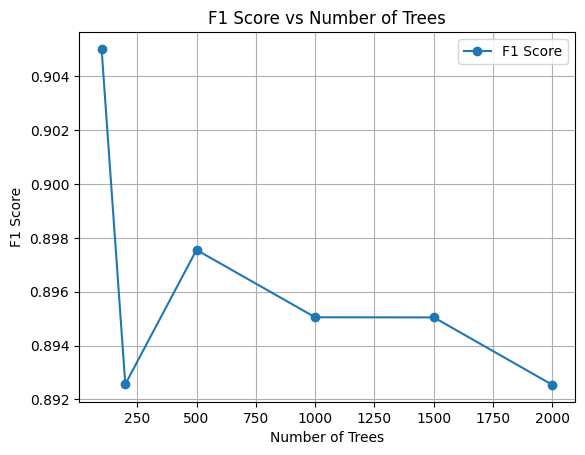

In [ ]:
f1_scores = []
n_dim = 100
n_samples = 2000
n_trees = [100, 200, 500, 1000, 1500, 2000]  
for n_tree in n_trees:
    num_dims = [5, 10, 20, 50, 100, 200, 400, 600, 800]
    f1_value, _ = compare_confusion_matrix(n_tree, n_dim, n_samples, params_treeple, params_ydf)
    f1_scores.append(f1_value)


plt.plot(n_trees, f1_scores, marker='o', label='F1 Score')
plt.xlabel('Number of Trees')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Number of Trees')
plt.grid(True)
plt.legend()
plt.show()

In [30]:
# compare_confusion_matrix(n_tree, n_dim, n_samples, params_treeple1, params_ydf1)
n_tree = 500
n_dim = 200
n_samples = 2000
compare_confusion_matrix(n_tree, n_dim, n_samples, params_treeple, params_ydf)

c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.8100, Training Time = 6.5569 sec
Train model on 1600 examples
Model trained in 0:00:04.203436
YDF | n_dim: 200 | n_tree: 500 | Accuracy: 0.7650 | Train Time: 4.2099 sec
Confusion Matrix for YDF Predictions:
[[179  19]
 [ 15 187]]


In [31]:
# compare_confusion_matrix(n_tree, n_dim, n_samples, params_treeple1, params_ydf1)
n_tree = 500
n_dim = 100
n_samples = 2000
compare_confusion_matrix(n_tree, n_dim, n_samples, params_treeple, params_ydf)

c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7750, Training Time = 3.4250 sec
Train model on 1600 examples
Model trained in 0:00:01.869056
YDF | n_dim: 100 | n_tree: 500 | Accuracy: 0.7275 | Train Time: 1.8741 sec
Confusion Matrix for YDF Predictions:
[[188  18]
 [ 23 171]]


In [32]:
# compare_confusion_matrix(n_tree, n_dim, n_samples, params_treeple1, params_ydf1)
n_tree = 500
n_dim = 500
n_samples = 2000
compare_confusion_matrix(n_tree, n_dim, n_samples, params_treeple, params_ydf)

c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 500. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7900, Training Time = 18.9392 sec
Train model on 1600 examples
Model trained in 0:00:13.657105
YDF | n_dim: 500 | n_tree: 500 | Accuracy: 0.7575 | Train Time: 13.6732 sec
Confusion Matrix for YDF Predictions:
[[191  19]
 [ 12 178]]


# trunk simulation

n_dim: 10 | n_tree: [10, 20, 40, 80, 100, 200] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.362667
Treeple: Accuracy = 0.7525, Training Time = 1.1442 sec
Train model on 1600 examples
Model trained in 0:00:00.358119
Treeple: Accuracy = 0.7525, Training Time = 1.1642 sec
Train model on 1600 examples
Model trained in 0:00:00.358810
Treeple: Accuracy = 0.7525, Training Time = 1.1420 sec
n_dim: 20 | n_tree: [10, 20, 40, 80, 100, 200] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.725282
Treeple: Accuracy = 0.7800, Training Time = 1.6366 sec
Train model on 1600 examples
Model trained in 0:00:00.697970
Treeple: Accuracy = 0.7800, Training Time = 1.6935 sec
Train model on 1600 examples
Model trained in 0:00:00.730010
Treeple: Accuracy = 0.7800, Training Time = 1.7170 sec
n_dim: 40 | n_tree: [10, 20, 40, 80, 100, 200] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 40. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.500622
Treeple: Accuracy = 0.8300, Training Time = 3.0960 sec
Train model on 1600 examples
Model trained in 0:00:01.504805
Treeple: Accuracy = 0.8300, Training Time = 3.0471 sec
Train model on 1600 examples
Model trained in 0:00:01.502982
Treeple: Accuracy = 0.8300, Training Time = 3.1651 sec
n_dim: 80 | n_tree: [10, 20, 40, 80, 100, 200] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 80. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:03.133011
Treeple: Accuracy = 0.8200, Training Time = 5.9501 sec
Train model on 1600 examples
Model trained in 0:00:03.228905
Treeple: Accuracy = 0.8200, Training Time = 5.8307 sec
Train model on 1600 examples
Model trained in 0:00:03.157718
Treeple: Accuracy = 0.8200, Training Time = 5.6166 sec
n_dim: 100 | n_tree: [10, 20, 40, 80, 100, 200] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:04.226278
Treeple: Accuracy = 0.7750, Training Time = 6.8888 sec
Train model on 1600 examples
Model trained in 0:00:04.261197
Treeple: Accuracy = 0.7750, Training Time = 7.4327 sec
Train model on 1600 examples
Model trained in 0:00:03.851151
Treeple: Accuracy = 0.7750, Training Time = 6.8705 sec
n_dim: 200 | n_tree: [10, 20, 40, 80, 100, 200] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:08.992781
Treeple: Accuracy = 0.8175, Training Time = 13.3619 sec
Train model on 1600 examples
Model trained in 0:00:08.646661
Treeple: Accuracy = 0.8175, Training Time = 14.1059 sec
Train model on 1600 examples
Model trained in 0:00:08.921597
Treeple: Accuracy = 0.8175, Training Time = 14.2167 sec


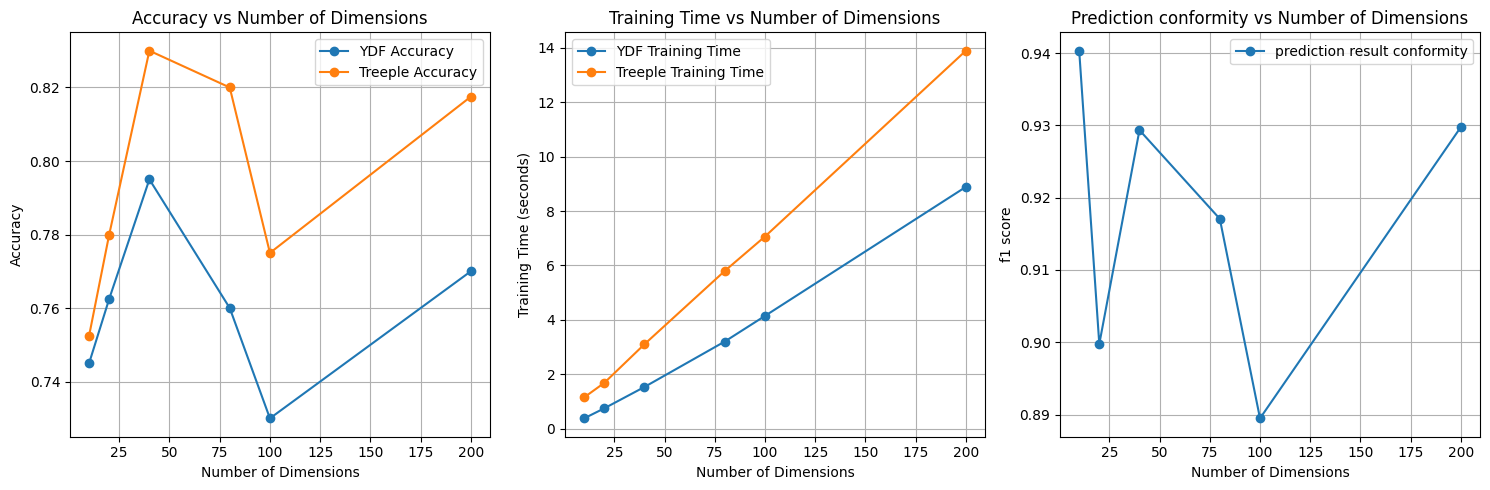

In [24]:
# trunk_simulation(n_tree, num_dims, 
#       n_samples, params_treeple, params_ydf, n_rep=5, plot=True):
n_tree = 1000
num_dims = [10, 20, 40, 80, 100, 200]
n_samples = 2000
accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores = trunk_simulation(num_dims, 
                                                                               num_dims, 
                                                                               n_samples, 
                                                                               params_treeple, 
                                                                               params_ydf, 
                                                                               n_rep=3, 
                                                                               plot=True)

n_dim: 10 | n_tree: [10, 100, 200, 500, 1000, 1500] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.388251
Treeple: Accuracy = 0.7525, Training Time = 1.0997 sec
Train model on 1600 examples
Model trained in 0:00:00.359435
Treeple: Accuracy = 0.7525, Training Time = 1.1479 sec
Train model on 1600 examples
Model trained in 0:00:00.360161
Treeple: Accuracy = 0.7525, Training Time = 1.1100 sec
n_dim: 100 | n_tree: [10, 100, 200, 500, 1000, 1500] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:03.756913
Treeple: Accuracy = 0.7750, Training Time = 6.9519 sec
Train model on 1600 examples
Model trained in 0:00:03.973726
Treeple: Accuracy = 0.7750, Training Time = 6.7220 sec
Train model on 1600 examples
Model trained in 0:00:03.983926
Treeple: Accuracy = 0.7750, Training Time = 6.9089 sec
n_dim: 200 | n_tree: [10, 100, 200, 500, 1000, 1500] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:09.071990
Treeple: Accuracy = 0.8175, Training Time = 13.7877 sec
Train model on 1600 examples
Model trained in 0:00:08.464264
Treeple: Accuracy = 0.8175, Training Time = 14.9518 sec
Train model on 1600 examples
Model trained in 0:00:09.208511
Treeple: Accuracy = 0.8175, Training Time = 14.0900 sec
n_dim: 500 | n_tree: [10, 100, 200, 500, 1000, 1500] | n_samples: 2000


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 500. Setting n_informative to n_dim.
  warnings.warn(


Train model on 1600 examples
Model trained in 0:00:28.235317
Treeple: Accuracy = 0.7850, Training Time = 37.4475 sec
Train model on 1600 examples
Model trained in 0:00:30.186836
Treeple: Accuracy = 0.7850, Training Time = 41.8919 sec
Train model on 1600 examples
Model trained in 0:00:28.234624
Treeple: Accuracy = 0.7850, Training Time = 39.1589 sec
n_dim: 1000 | n_tree: [10, 100, 200, 500, 1000, 1500] | n_samples: 2000
Train model on 1600 examples
Model trained in 0:01:17.281569
Treeple: Accuracy = 0.7650, Training Time = 98.8450 sec
Train model on 1600 examples
Model trained in 0:01:15.845704
Treeple: Accuracy = 0.7650, Training Time = 103.4741 sec
Train model on 1600 examples
Model trained in 0:01:14.638623
Treeple: Accuracy = 0.7650, Training Time = 102.7939 sec
n_dim: 1500 | n_tree: [10, 100, 200, 500, 1000, 1500] | n_samples: 2000
Train model on 1600 examples
Model trained in 0:02:20.007052
Treeple: Accuracy = 0.7500, Training Time = 336.4375 sec
Train model on 1600 examples
Model

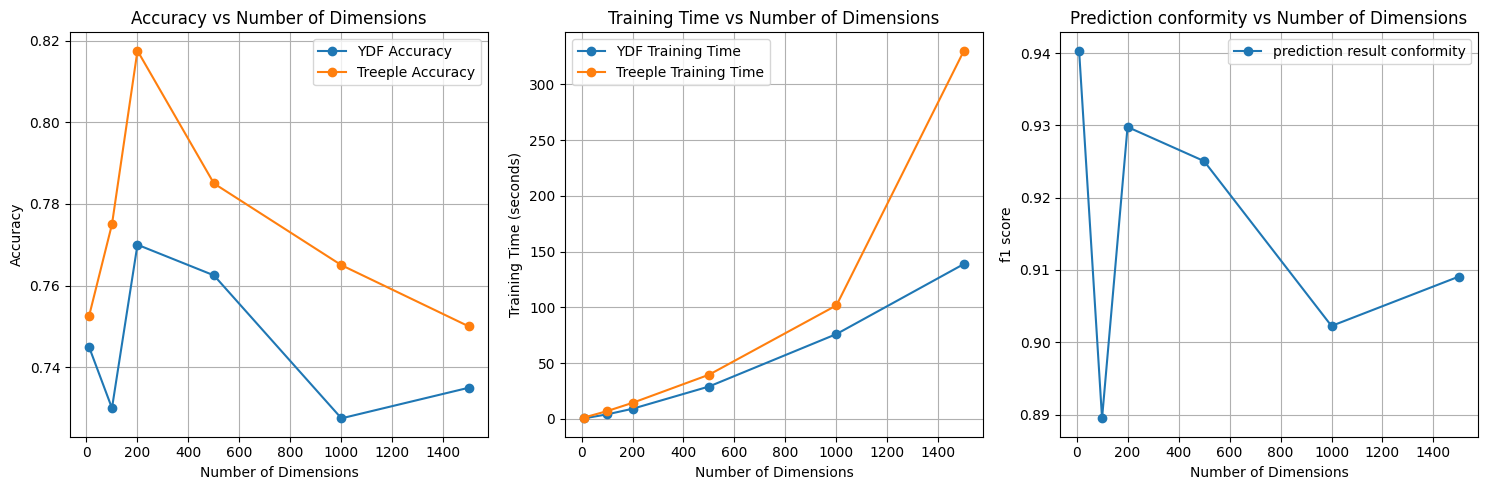

In [ ]:
# trunk_simulation(n_tree, num_dims, 
#       n_samples, params_treeple, params_ydf, n_rep=5, plot=True):
n_tree = 1000
num_dims = [10, 100, 200, 500, 1000, 1500]
n_samples = 2000
accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores = trunk_simulation(n_tree, 
                                                                               num_dims, 
                                                                               n_samples, 
                                                                               params_treeple, 
                                                                               params_ydf, 
                                                                               n_rep=3, 
                                                                               plot=True)

In [50]:
params_ydf1 = params_ydf.copy()
params_ydf1["sparse_oblique_max_num_projections"] = 2000

n_tree = 500
num_dims = 1500
n_samples = 2000


compare_confusion_matrix(n_tree, n_dim, n_samples, params_treeple, params_ydf1)

c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7750, Training Time = 3.2534 sec
Train model on 1600 examples
Model trained in 0:00:01.897807
YDF | n_dim: 100 | n_tree: 500 | Accuracy: 0.7275 | Train Time: 1.9018 sec
Confusion Matrix for YDF Predictions:
[[188  18]
 [ 23 171]]


0.8975545516589338

In [52]:
params_ydf

{'label': 'target',
 'max_depth': 10,
 'num_trees': 1000,
 'random_seed': 42,
 'honest': False,
 'bootstrap_size_ratio': 1.0,
 'bootstrap_training_dataset': True,
 'categorical_algorithm': 'ONE_HOT',
 'split_axis': 'SPARSE_OBLIQUE',
 'compute_oob_performances': False,
 'compute_oob_variable_importances': False,
 'max_num_nodes': None,
 'growing_strategy': 'BEST_FIRST_GLOBAL',
 'num_candidate_attributes': 1,
 'sorting_strategy': 'IN_NODE',
 'sparse_oblique_weights': 'CONTINUOUS',
 'sparse_oblique_projection_density_factor': 1.0,
 'sparse_oblique_normalization': 'MIN_MAX',
 'sparse_oblique_max_num_projections': 6000,
 'sparse_oblique_num_projections_exponent': 1.0,
 'sampling_with_replacement': False}

n_dim: 10 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.191650
Treeple: Accuracy = 0.7450, Training Time = 3.3116 sec
Train model on 1600 examples
Model trained in 0:00:00.178504
Treeple: Accuracy = 0.7450, Training Time = 3.4457 sec
Train model on 1600 examples
Model trained in 0:00:00.185643
Treeple: Accuracy = 0.7450, Training Time = 3.4522 sec
n_dim: 20 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.355021
Treeple: Accuracy = 0.7775, Training Time = 3.2023 sec
Train model on 1600 examples
Model trained in 0:00:00.402785
Treeple: Accuracy = 0.7775, Training Time = 3.1709 sec
Train model on 1600 examples
Model trained in 0:00:00.360436
Treeple: Accuracy = 0.7775, Training Time = 3.1992 sec
n_dim: 40 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 40. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.715086
Treeple: Accuracy = 0.8300, Training Time = 3.2429 sec
Train model on 1600 examples
Model trained in 0:00:00.722544
Treeple: Accuracy = 0.8300, Training Time = 3.2088 sec
Train model on 1600 examples
Model trained in 0:00:00.750248
Treeple: Accuracy = 0.8300, Training Time = 3.2118 sec
n_dim: 60 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 60. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.168926
Treeple: Accuracy = 0.7850, Training Time = 3.4576 sec
Train model on 1600 examples
Model trained in 0:00:01.144765
Treeple: Accuracy = 0.7850, Training Time = 3.2023 sec
Train model on 1600 examples
Model trained in 0:00:01.084098
Treeple: Accuracy = 0.7850, Training Time = 3.2704 sec
n_dim: 80 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 80. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.623464
Treeple: Accuracy = 0.8175, Training Time = 3.2907 sec
Train model on 1600 examples
Model trained in 0:00:01.484322
Treeple: Accuracy = 0.8175, Training Time = 3.4313 sec
Train model on 1600 examples
Model trained in 0:00:01.501521
Treeple: Accuracy = 0.8175, Training Time = 3.3551 sec
n_dim: 100 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.885233
Treeple: Accuracy = 0.7750, Training Time = 3.3541 sec
Train model on 1600 examples
Model trained in 0:00:01.901786
Treeple: Accuracy = 0.7750, Training Time = 3.3664 sec
Train model on 1600 examples
Model trained in 0:00:02.033335
Treeple: Accuracy = 0.7750, Training Time = 3.3792 sec
n_dim: 200 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:02.168578
Treeple: Accuracy = 0.8175, Training Time = 3.4815 sec
Train model on 1600 examples
Model trained in 0:00:02.156497
Treeple: Accuracy = 0.8175, Training Time = 3.4584 sec
Train model on 1600 examples
Model trained in 0:00:02.079698
Treeple: Accuracy = 0.8175, Training Time = 3.4487 sec
n_dim: 400 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 400. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:02.499707
Treeple: Accuracy = 0.8300, Training Time = 3.8507 sec
Train model on 1600 examples
Model trained in 0:00:02.476780
Treeple: Accuracy = 0.8300, Training Time = 3.8523 sec
Train model on 1600 examples
Model trained in 0:00:02.476976
Treeple: Accuracy = 0.8300, Training Time = 3.8507 sec
n_dim: 600 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:02.853150
Treeple: Accuracy = 0.8025, Training Time = 4.2206 sec
Train model on 1600 examples
Model trained in 0:00:02.887621
Treeple: Accuracy = 0.8025, Training Time = 4.2058 sec
Train model on 1600 examples
Model trained in 0:00:02.857379
Treeple: Accuracy = 0.8025, Training Time = 4.2167 sec
n_dim: 800 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:03.274390
Treeple: Accuracy = 0.8200, Training Time = 4.5798 sec
Train model on 1600 examples
Model trained in 0:00:03.241312
Treeple: Accuracy = 0.8200, Training Time = 4.5562 sec
Train model on 

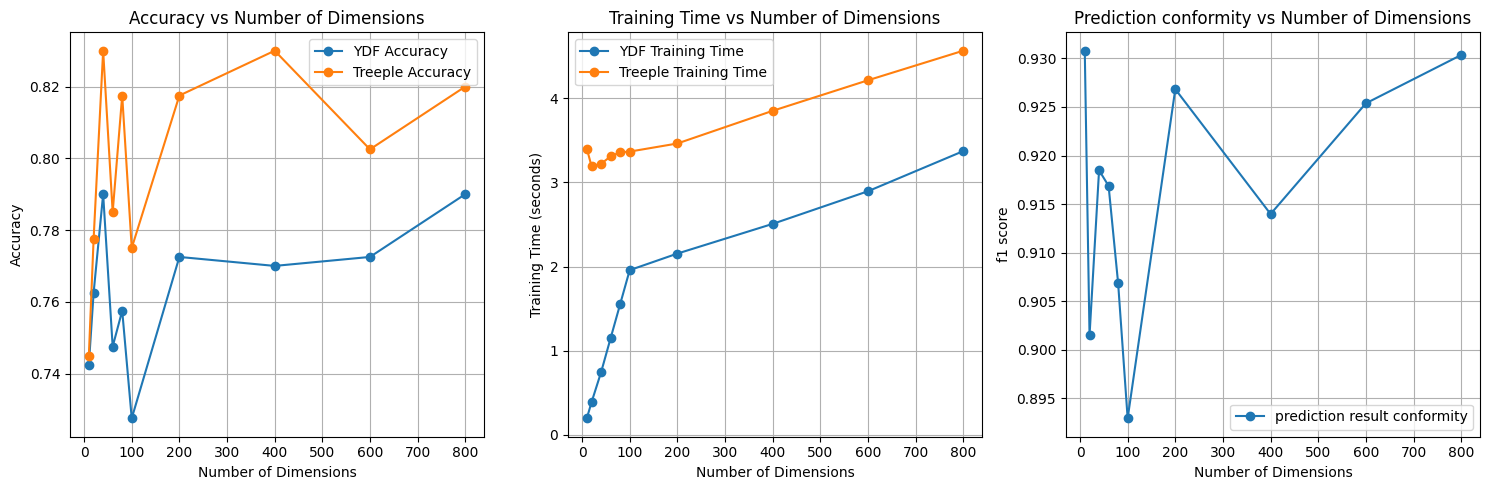

In [56]:
# trunk_simulation(n_tree, num_dims, 
#       n_samples, params_treeple, params_ydf, n_rep=5, plot=True):


params_ydf1 = params_ydf.copy()
params_ydf1["sparse_oblique_max_num_projections"] = 100

params_treeple1 = params_treeple.copy() 
params_treeple1["max_features"] = 100


n_tree = 500
num_dims = [10, 20, 40, 60, 80, 100, 200, 400, 600, 800, 1000, 1500, 2000]
n_samples = 2000
accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores = trunk_simulation(n_tree, 
                                                                               num_dims, 
                                                                               n_samples, 
                                                                               params_treeple1, 
                                                                               params_ydf1, 
                                                                               n_rep=3, 
                                                                               plot=True)

In [12]:
params_ydf

{'label': 'target',
 'max_depth': 10,
 'num_trees': 1000,
 'random_seed': 42,
 'honest': False,
 'bootstrap_size_ratio': 1.0,
 'bootstrap_training_dataset': True,
 'categorical_algorithm': 'ONE_HOT',
 'split_axis': 'SPARSE_OBLIQUE',
 'compute_oob_performances': False,
 'compute_oob_variable_importances': False,
 'max_num_nodes': None,
 'growing_strategy': 'BEST_FIRST_GLOBAL',
 'num_candidate_attributes': 1,
 'sorting_strategy': 'IN_NODE',
 'sparse_oblique_weights': 'CONTINUOUS',
 'sparse_oblique_projection_density_factor': 1.0,
 'sparse_oblique_normalization': 'MIN_MAX',
 'sparse_oblique_max_num_projections': 6000,
 'sparse_oblique_num_projections_exponent': 1.0,
 'sampling_with_replacement': False}

highlighted cell here!

n_dim: 10 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.222359
Treeple: Accuracy = 0.7625, Training Time = 5.0481 sec
Train model on 1600 examples
Model trained in 0:00:00.207354
Treeple: Accuracy = 0.7625, Training Time = 5.0180 sec
n_dim: 20 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.400775
Treeple: Accuracy = 0.8000, Training Time = 4.8239 sec
Train model on 1600 examples
Model trained in 0:00:00.403291
Treeple: Accuracy = 0.8000, Training Time = 4.7631 sec
n_dim: 40 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 40. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.815135
Treeple: Accuracy = 0.8525, Training Time = 4.8646 sec
Train model on 1600 examples
Model trained in 0:00:00.800425
Treeple: Accuracy = 0.8525, Training Time = 4.8286 sec
n_dim: 60 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 60. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.240286
Treeple: Accuracy = 0.8075, Training Time = 4.9634 sec
Train model on 1600 examples
Model trained in 0:00:01.291924
Treeple: Accuracy = 0.8075, Training Time = 4.8894 sec
n_dim: 80 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 80. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.732235
Treeple: Accuracy = 0.8425, Training Time = 5.2157 sec
Train model on 1600 examples
Model trained in 0:00:01.707950
Treeple: Accuracy = 0.8425, Training Time = 5.4013 sec
n_dim: 100 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:02.190516
Treeple: Accuracy = 0.8125, Training Time = 5.2097 sec
Train model on 1600 examples
Model trained in 0:00:02.180152
Treeple: Accuracy = 0.8125, Training Time = 5.1797 sec
n_dim: 200 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:02.391193
Treeple: Accuracy = 0.8350, Training Time = 5.5361 sec
Train model on 1600 examples
Model trained in 0:00:02.528979
Treeple: Accuracy = 0.8350, Training Time = 5.5597 sec
n_dim: 400 | n_tree: 500 | n_samples: 2000


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 400. Setting n_informative to n_dim.
  warnings.warn(


Train model on 1600 examples
Model trained in 0:00:02.897175
Treeple: Accuracy = 0.8300, Training Time = 5.7757 sec
Train model on 1600 examples
Model trained in 0:00:03.051139
Treeple: Accuracy = 0.8300, Training Time = 6.1481 sec
n_dim: 600 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:03.510403
Treeple: Accuracy = 0.8250, Training Time = 6.2891 sec
Train model on 1600 examples
Model trained in 0:00:03.339111
Treeple: Accuracy = 0.8250, Training Time = 6.1984 sec
n_dim: 800 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:04.042493
Treeple: Accuracy = 0.8275, Training Time = 6.9376 sec
Train model on 1600 examples
Model trained in 0:00:03.918576
Treeple: Accuracy = 0.8275, Training Time = 6.4250 sec
n_dim: 1000 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:04.186587
Treeple: Accuracy = 0.8125, Training Time = 6.8566 sec
Train model on 1600 examples
Model trained in 0:00:04.2184

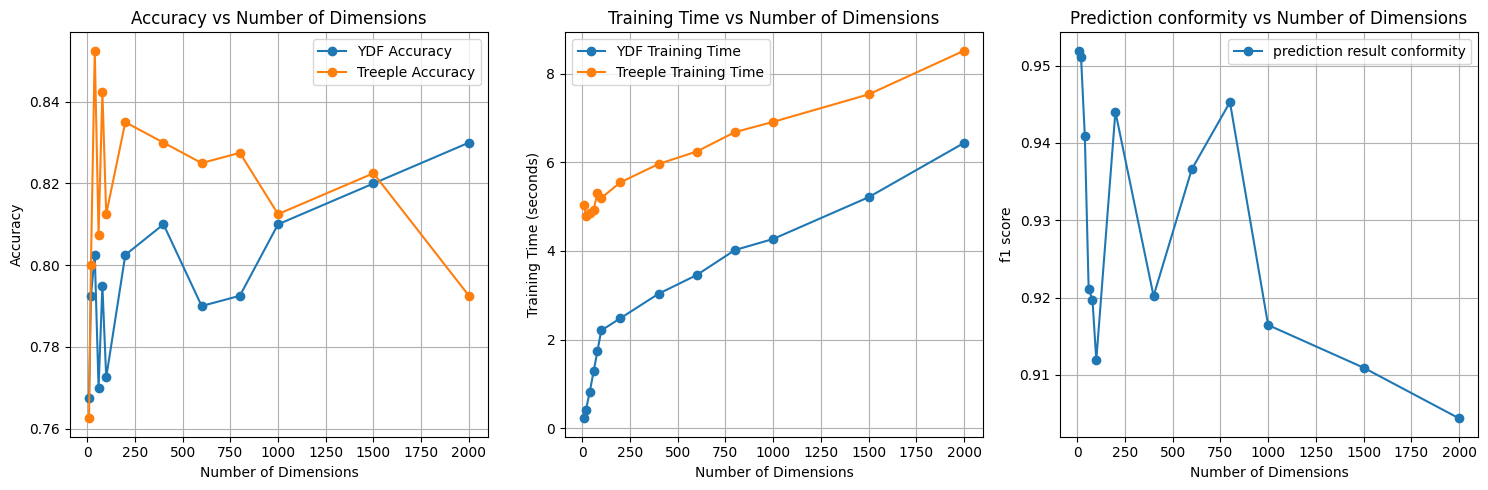

In [15]:
# trunk_simulation(n_tree, num_dims, 
#       n_samples, params_treeple, params_ydf, n_rep=5, plot=True):

MAX_FEATURES = 100
params_ydf1 = params_ydf.copy()
params_ydf1["sparse_oblique_max_num_projections"] = MAX_FEATURES
params_ydf1["sparse_oblique_projection_density_factor"] = 3.0

params_treeple1 = params_treeple.copy() 
params_treeple1["max_features"] = MAX_FEATURES
params_treeple1["feature_combinations"] = 3.0
params_treeple1["max_depth"] = MAX_DEPTH



n_tree = 500
num_dims = [10, 20, 40, 60, 80, 100, 200, 400, 600, 800, 1000, 1500, 2000]
n_samples = 2000
accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores = trunk_simulation(n_tree, 
                                                                               num_dims, 
                                                                               n_samples, 
                                                                               params_treeple1, 
                                                                               params_ydf1, 
                                                                               n_rep=2, 
                                                                               plot=True)

n_dim: 10 | n_tree: 300 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.131228


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7725, Training Time = 14.8991 sec
n_dim: 20 | n_tree: 300 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.242820
Treeple: Accuracy = 0.7925, Training Time = 13.4620 sec
n_dim: 40 | n_tree: 300 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 40. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.484619
Treeple: Accuracy = 0.8575, Training Time = 13.2699 sec
n_dim: 60 | n_tree: 300 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 60. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.694418
Treeple: Accuracy = 0.8150, Training Time = 12.8216 sec
n_dim: 80 | n_tree: 300 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 80. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.009007
Treeple: Accuracy = 0.8450, Training Time = 13.0899 sec
n_dim: 100 | n_tree: 300 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.234346
Treeple: Accuracy = 0.7950, Training Time = 12.9690 sec
n_dim: 200 | n_tree: 300 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:02.664982
Treeple: Accuracy = 0.8150, Training Time = 14.0610 sec
n_dim: 400 | n_tree: 300 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 400. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:06.491001
Treeple: Accuracy = 0.8025, Training Time = 15.7234 sec
n_dim: 600 | n_tree: 300 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:08.902136
Treeple: Accuracy = 0.8025, Training Time = 16.4857 sec
n_dim: 800 | n_tree: 300 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:09.970133
Treeple: Accuracy = 0.7800, Training Time = 17.0104 sec
n_dim: 1000 | n_tree: 300 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:11.166819
Treeple: Accuracy = 0.7800, Training Time = 18.4806 sec
n_dim: 1500 | n_tree: 300 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:14.088477
Treeple: Accuracy = 0.7700, Training Time = 22.6174 sec
n_dim: 2000 | n_tree: 300 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:18.173025
Treeple: Accuracy = 0.7675, Training Time = 27.9622 sec


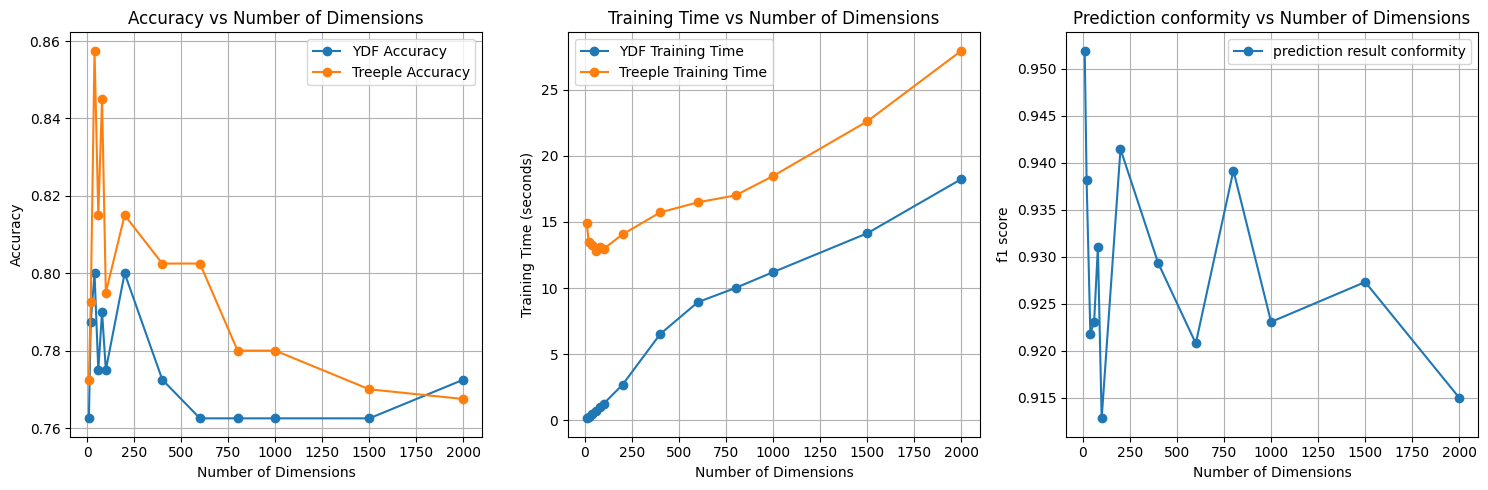

In [18]:
# trunk_simulation(n_tree, num_dims, 
#       n_samples, params_treeple, params_ydf, n_rep=5, plot=True):

MAX_FEATURES = 500
params_ydf1 = params_ydf.copy()
params_ydf1["sparse_oblique_max_num_projections"] = MAX_FEATURES
params_ydf1["sparse_oblique_projection_density_factor"] = 3.0

params_treeple1 = params_treeple.copy() 
params_treeple1["max_features"] = MAX_FEATURES
params_treeple1["feature_combinations"] = 3.0
params_treeple1["max_depth"] = MAX_DEPTH



n_tree = 300
num_dims = [10, 20, 40, 60, 80, 100, 200, 400, 600, 800, 1000, 1500, 2000]
n_samples = 2000
accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores = trunk_simulation(n_tree, 
                                                                               num_dims, 
                                                                               n_samples, 
                                                                               params_treeple1, 
                                                                               params_ydf1, 
                                                                               n_rep=1, 
                                                                               plot=True)

n_dim: 10 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.040291


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7625, Training Time = 5.0560 sec
Train model on 1600 examples
Model trained in 0:00:00.037945
Treeple: Accuracy = 0.7625, Training Time = 5.0651 sec
n_dim: 20 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.045133


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.8000, Training Time = 5.0590 sec
Train model on 1600 examples
Model trained in 0:00:00.042092
Treeple: Accuracy = 0.8000, Training Time = 4.8627 sec
n_dim: 40 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.044074


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 40. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.8525, Training Time = 5.1014 sec
Train model on 1600 examples
Model trained in 0:00:00.042094
Treeple: Accuracy = 0.8525, Training Time = 5.0278 sec
n_dim: 60 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.050127


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 60. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.8075, Training Time = 5.3867 sec
Train model on 1600 examples
Model trained in 0:00:00.050152
Treeple: Accuracy = 0.8075, Training Time = 5.2153 sec
n_dim: 80 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.052301


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 80. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.8425, Training Time = 5.1909 sec
Train model on 1600 examples
Model trained in 0:00:00.049236
Treeple: Accuracy = 0.8425, Training Time = 5.1759 sec
n_dim: 100 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.058709


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.8125, Training Time = 5.5545 sec
Train model on 1600 examples
Model trained in 0:00:00.062160
Treeple: Accuracy = 0.8125, Training Time = 5.5202 sec
n_dim: 200 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.068946


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.8350, Training Time = 5.7294 sec
Train model on 1600 examples
Model trained in 0:00:00.061122
Treeple: Accuracy = 0.8350, Training Time = 5.3453 sec
n_dim: 400 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 400. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.085932
Treeple: Accuracy = 0.8300, Training Time = 5.8009 sec
Train model on 1600 examples
Model trained in 0:00:00.083564
Treeple: Accuracy = 0.8300, Training Time = 5.7018 sec
n_dim: 600 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.099734
Treeple: Accuracy = 0.8250, Training Time = 6.0076 sec
Train model on 1600 examples
Model trained in 0:00:00.096793
Treeple: Accuracy = 0.8250, Training Time = 6.1610 sec
n_dim: 800 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.122724
Treeple: Accuracy = 0.8275, Training Time = 6.4110 sec
Train model on 1600 examples
Model trained in 0:00:00.120461
Treeple: Accuracy = 0.8275, Training Time = 6.5487 sec
n_dim: 1000 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.141440
Treeple: Accuracy = 0.8125, Training Time = 6.7536 sec
Train model on 1600 examples
Model trained in 0:00:00.146067
Treeple: Accuracy = 0.8125

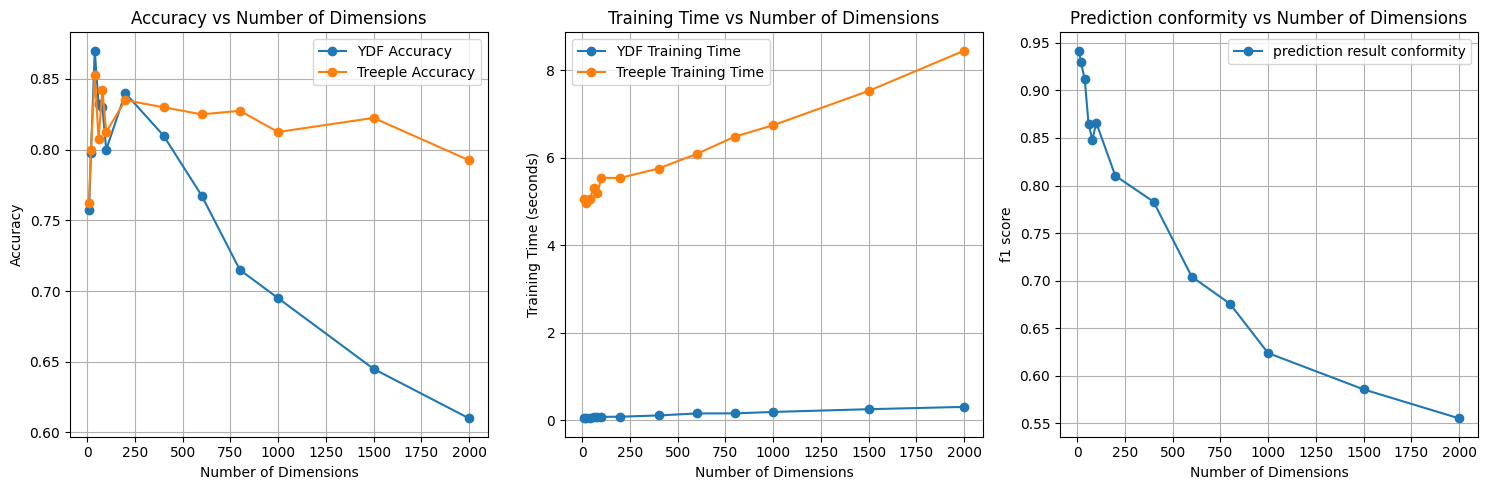

In [16]:
# trunk_simulation(n_tree, num_dims, 
#       n_samples, params_treeple, params_ydf, n_rep=5, plot=True):

MAX_FEATURES = 100
params_ydf1 = params_ydf.copy()
params_ydf1["sparse_oblique_max_num_projections"] = MAX_FEATURES
params_ydf1["sparse_oblique_projection_density_factor"] = 3.0
params_ydf1["sparse_oblique_num_projections_exponent"] = 10.0

params_treeple1 = params_treeple.copy() 
params_treeple1["max_features"] = MAX_FEATURES
params_treeple1["feature_combinations"] = 3.0
params_treeple1["max_depth"] = MAX_DEPTH



n_tree = 500
num_dims = [10, 20, 40, 60, 80, 100, 200, 400, 600, 800, 1000, 1500, 2000]
n_samples = 2000
accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores = trunk_simulation(n_tree, 
                                                                               num_dims, 
                                                                               n_samples, 
                                                                               params_treeple1, 
                                                                               params_ydf1, 
                                                                               n_rep=2, 
                                                                               plot=True)

In [66]:
params_ydf

{'label': 'target',
 'max_depth': 10,
 'num_trees': 1000,
 'random_seed': 42,
 'honest': False,
 'bootstrap_size_ratio': 1.0,
 'bootstrap_training_dataset': True,
 'categorical_algorithm': 'ONE_HOT',
 'split_axis': 'SPARSE_OBLIQUE',
 'compute_oob_performances': False,
 'compute_oob_variable_importances': False,
 'max_num_nodes': None,
 'growing_strategy': 'BEST_FIRST_GLOBAL',
 'num_candidate_attributes': 1,
 'sorting_strategy': 'IN_NODE',
 'sparse_oblique_weights': 'CONTINUOUS',
 'sparse_oblique_projection_density_factor': 1.0,
 'sparse_oblique_normalization': 'MIN_MAX',
 'sparse_oblique_max_num_projections': 6000,
 'sparse_oblique_num_projections_exponent': 1.0,
 'sampling_with_replacement': False}

n_dim: 10 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.223987
Treeple: Accuracy = 0.7450, Training Time = 3.3943 sec
n_dim: 20 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.402521
Treeple: Accuracy = 0.7775, Training Time = 3.2328 sec
n_dim: 40 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 40. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.768805
Treeple: Accuracy = 0.8300, Training Time = 3.0986 sec
n_dim: 60 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 60. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.161120
Treeple: Accuracy = 0.7850, Training Time = 3.0853 sec
n_dim: 80 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 80. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.600823
Treeple: Accuracy = 0.8175, Training Time = 3.2175 sec
n_dim: 100 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:02.010183
Treeple: Accuracy = 0.7750, Training Time = 3.1824 sec
n_dim: 200 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:02.253141
Treeple: Accuracy = 0.8175, Training Time = 3.4258 sec
n_dim: 400 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 400. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:02.666045
Treeple: Accuracy = 0.8300, Training Time = 3.8486 sec
n_dim: 600 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:03.025514
Treeple: Accuracy = 0.8025, Training Time = 4.1634 sec
n_dim: 800 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:03.408490
Treeple: Accuracy = 0.8200, Training Time = 4.4976 sec
n_dim: 1000 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:03.767210
Treeple: Accuracy = 0.7875, Training Time = 4.8597 sec
n_dim: 1500 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:04.703337
Treeple: Accuracy = 0.8175, Training Time = 5.7373 sec
n_dim: 2000 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:05.590087
Treeple: Accuracy = 0.8100, Training Time = 6.7157 sec
n_dim: 2500 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:06.541399
Treeple: A

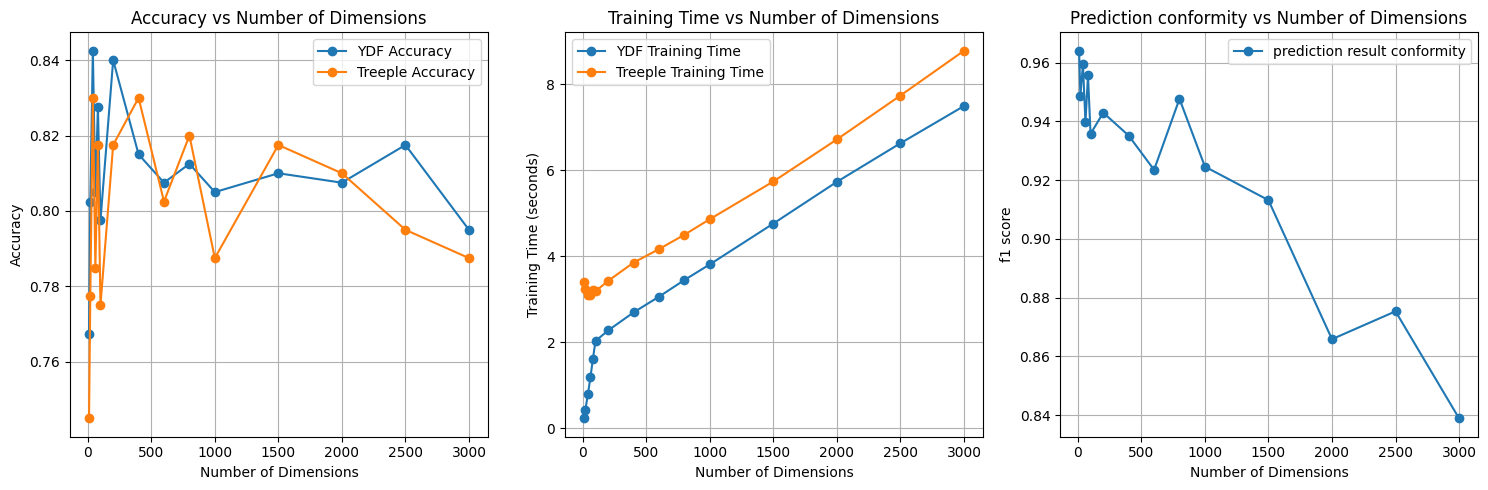

In [86]:
# trunk_simulation(n_tree, num_dims, 
#       n_samples, params_treeple, params_ydf, n_rep=5, plot=True):

MAX_FEATURES = 100
params_ydf1 = params_ydf.copy()
params_ydf1["sparse_oblique_max_num_projections"] = MAX_FEATURES
params_ydf1["sparse_oblique_num_projections_exponent"] = 1.0
params_ydf1["sparse_oblique_projection_density_factor"] = 5.0

params_treeple1 = params_treeple.copy() 
params_treeple1["max_features"] = MAX_FEATURES


n_tree = 500
num_dims = [10, 20, 40, 60, 80, 100, 200, 400, 600, 800, 1000, 1500, 2000, 2500, 3000]
n_samples = 2000
accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores = trunk_simulation(n_tree, 
                                                                               num_dims, 
                                                                               n_samples, 
                                                                               params_treeple1, 
                                                                               params_ydf1, 
                                                                               n_rep=1, 
                                                                               plot=True)

n_dim: 10 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.218993
Treeple: Accuracy = 0.7550, Training Time = 4.0613 sec
n_dim: 20 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.405985
Treeple: Accuracy = 0.7975, Training Time = 3.8547 sec
n_dim: 40 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 40. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.770528
Treeple: Accuracy = 0.8375, Training Time = 3.8557 sec
n_dim: 60 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 60. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.176841
Treeple: Accuracy = 0.7900, Training Time = 3.8676 sec
n_dim: 80 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 80. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.573555
Treeple: Accuracy = 0.8225, Training Time = 3.9083 sec
n_dim: 100 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.993241
Treeple: Accuracy = 0.7775, Training Time = 3.9116 sec
n_dim: 200 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:03.223205
Treeple: Accuracy = 0.8375, Training Time = 4.1812 sec
n_dim: 400 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 400. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:03.937188
Treeple: Accuracy = 0.8200, Training Time = 4.5733 sec
n_dim: 600 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:04.540636
Treeple: Accuracy = 0.8075, Training Time = 5.0467 sec
n_dim: 800 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:05.036635
Treeple: Accuracy = 0.7975, Training Time = 5.2939 sec
n_dim: 1000 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:05.449905
Treeple: Accuracy = 0.8175, Training Time = 5.5555 sec
n_dim: 1500 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:06.799328
Treeple: Accuracy = 0.7825, Training Time = 6.4151 sec
n_dim: 2000 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:08.143880
Treeple: Accuracy = 0.8000, Training Time = 7.3041 sec
n_dim: 2500 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:10.049525
Treeple: A

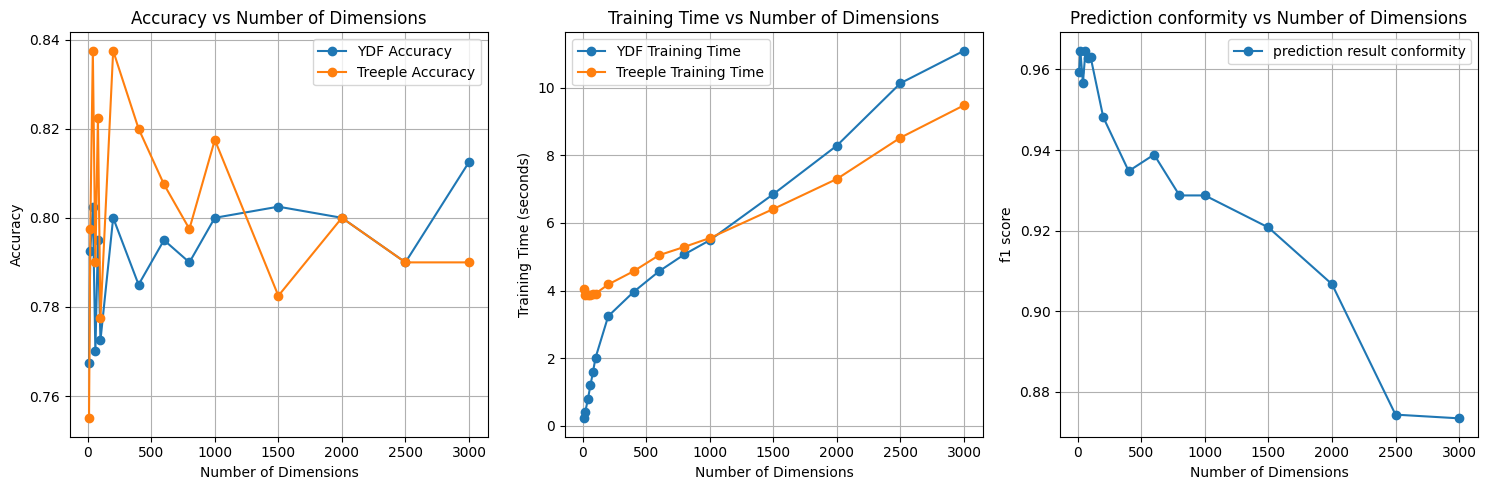

In [ ]:
# trunk_simulation(n_tree, num_dims, 
#       n_samples, params_treeple, params_ydf, n_rep=5, plot=True):

MAX_FEATURES = 100
params_ydf1 = params_ydf.copy()
params_ydf1["sparse_oblique_max_num_projections"] = 150
params_ydf1["sparse_oblique_num_projections_exponent"] = 1.0
params_ydf1["sparse_oblique_projection_density_factor"] = 3.0

params_treeple1 = params_treeple.copy() 
params_treeple1["max_features"] = MAX_FEATURES
params_treeple1["feature_combinations"] = 1.5


n_tree = 500
num_dims = [10, 20, 40, 60, 80, 100, 200, 400, 600, 800, 1000, 1500, 2000, 2500, 3000]
n_samples = 2000
accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores = trunk_simulation(n_tree, 
                                                                               num_dims, 
                                                                               n_samples, 
                                                                               params_treeple1, 
                                                                               params_ydf1, 
                                                                               n_rep=1, 
                                                                               plot=True)

n_dim: 10 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.215991
Treeple: Accuracy = 0.7550, Training Time = 3.9351 sec
Train model on 1600 examples
Model trained in 0:00:00.190992
Treeple: Accuracy = 0.7550, Training Time = 3.9149 sec
Train model on 1600 examples
Model trained in 0:00:00.195993
Treeple: Accuracy = 0.7550, Training Time = 3.9198 sec
n_dim: 20 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.366410
Treeple: Accuracy = 0.7975, Training Time = 3.6995 sec
Train model on 1600 examples
Model trained in 0:00:00.371711
Treeple: Accuracy = 0.7975, Training Time = 3.7320 sec
Train model on 1600 examples
Model trained in 0:00:00.367520
Treeple: Accuracy = 0.7975, Training Time = 3.7025 sec
n_dim: 40 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 40. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.742974
Treeple: Accuracy = 0.8375, Training Time = 3.7598 sec
Train model on 1600 examples
Model trained in 0:00:00.739975
Treeple: Accuracy = 0.8375, Training Time = 3.7169 sec
Train model on 1600 examples
Model trained in 0:00:00.768173
Treeple: Accuracy = 0.8375, Training Time = 3.7603 sec
n_dim: 60 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 60. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.121962
Treeple: Accuracy = 0.7900, Training Time = 3.8504 sec
Train model on 1600 examples
Model trained in 0:00:01.230321
Treeple: Accuracy = 0.7900, Training Time = 4.0790 sec
Train model on 1600 examples
Model trained in 0:00:01.197182
Treeple: Accuracy = 0.7900, Training Time = 3.8707 sec
n_dim: 80 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 80. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.545077
Treeple: Accuracy = 0.8225, Training Time = 3.8865 sec
Train model on 1600 examples
Model trained in 0:00:01.562238
Treeple: Accuracy = 0.8225, Training Time = 3.9841 sec
Train model on 1600 examples
Model trained in 0:00:01.571673
Treeple: Accuracy = 0.8225, Training Time = 3.9332 sec
n_dim: 100 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:02.061646
Treeple: Accuracy = 0.7775, Training Time = 3.9099 sec
Train model on 1600 examples
Model trained in 0:00:01.994007
Treeple: Accuracy = 0.7775, Training Time = 3.9143 sec
Train model on 1600 examples
Model trained in 0:00:02.062622
Treeple: Accuracy = 0.7775, Training Time = 3.9886 sec
n_dim: 200 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:03.366556
Treeple: Accuracy = 0.8375, Training Time = 4.2189 sec
Train model on 1600 examples
Model trained in 0:00:03.311956
Treeple: Accuracy = 0.8375, Training Time = 4.2686 sec
Train model on 1600 examples
Model trained in 0:00:03.411143
Treeple: Accuracy = 0.8375, Training Time = 4.4827 sec
n_dim: 400 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 400. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:04.139591
Treeple: Accuracy = 0.8200, Training Time = 4.9613 sec
Train model on 1600 examples
Model trained in 0:00:04.040306
Treeple: Accuracy = 0.8200, Training Time = 4.5432 sec
Train model on 1600 examples
Model trained in 0:00:03.789645
Treeple: Accuracy = 0.8200, Training Time = 4.5798 sec
n_dim: 600 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:04.343547
Treeple: Accuracy = 0.8075, Training Time = 4.8507 sec
Train model on 1600 examples
Model trained in 0:00:04.343804
Treeple: Accuracy = 0.8075, Training Time = 4.8807 sec
Train model on 1600 examples
Model trained in 0:00:04.367403
Treeple: Accuracy = 0.8075, Training Time = 4.8410 sec
n_dim: 800 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:04.893614
Treeple: Accuracy = 0.7975, Training Time = 5.2099 sec
Train model on 1600 examples
Model trained in 0:00:05.098878
Treeple: Accuracy = 0.7975, Training Time = 5.5457 sec
Train model on 

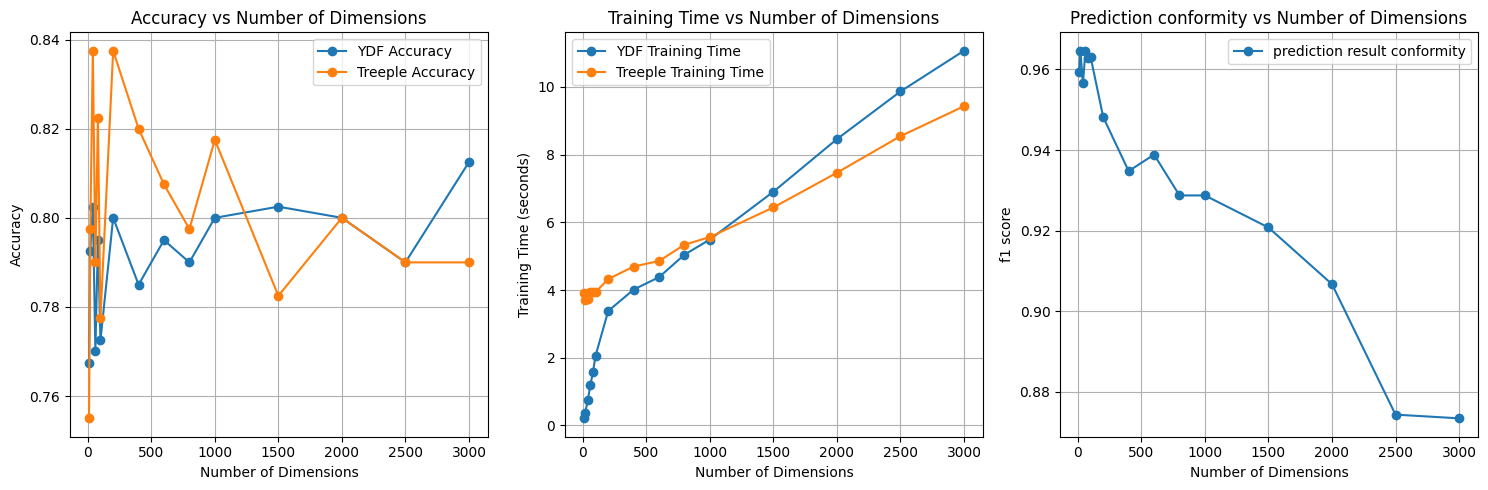

In [91]:
# trunk_simulation(n_tree, num_dims, 
#       n_samples, params_treeple, params_ydf, n_rep=5, plot=True):

MAX_FEATURES = 100
params_ydf1 = params_ydf.copy()
params_ydf1["sparse_oblique_max_num_projections"] = 150
params_ydf1["sparse_oblique_num_projections_exponent"] = 1.0
params_ydf1["sparse_oblique_projection_density_factor"] = 3.0

params_treeple1 = params_treeple.copy() 
params_treeple1["max_features"] = MAX_FEATURES
params_treeple1["feature_combinations"] = 1.5


n_tree = 500
num_dims = [10, 20, 40, 60, 80, 100, 200, 400, 600, 800, 1000, 1500, 2000, 2500, 3000]
n_samples = 2000
accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores2 = trunk_simulation(n_tree, 
                                                                               num_dims, 
                                                                               n_samples, 
                                                                               params_treeple1, 
                                                                               params_ydf1, 
                                                                               n_rep=3, 
                                                                               plot=True)

n_dim: 10 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.196993


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7500, Training Time = 5.7617 sec
n_dim: 20 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.372657
Treeple: Accuracy = 0.8025, Training Time = 5.4423 sec
n_dim: 40 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 40. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.742512
Treeple: Accuracy = 0.8325, Training Time = 5.4453 sec
n_dim: 60 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 60. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.130728
Treeple: Accuracy = 0.7900, Training Time = 5.4677 sec
n_dim: 80 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 80. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.540024
Treeple: Accuracy = 0.8175, Training Time = 5.6202 sec
n_dim: 100 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.971089
Treeple: Accuracy = 0.7750, Training Time = 5.7556 sec
n_dim: 200 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:03.200215
Treeple: Accuracy = 0.8225, Training Time = 5.9228 sec
n_dim: 400 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 400. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:03.816513
Treeple: Accuracy = 0.8175, Training Time = 6.4990 sec
n_dim: 600 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:04.460614
Treeple: Accuracy = 0.8125, Training Time = 7.2072 sec


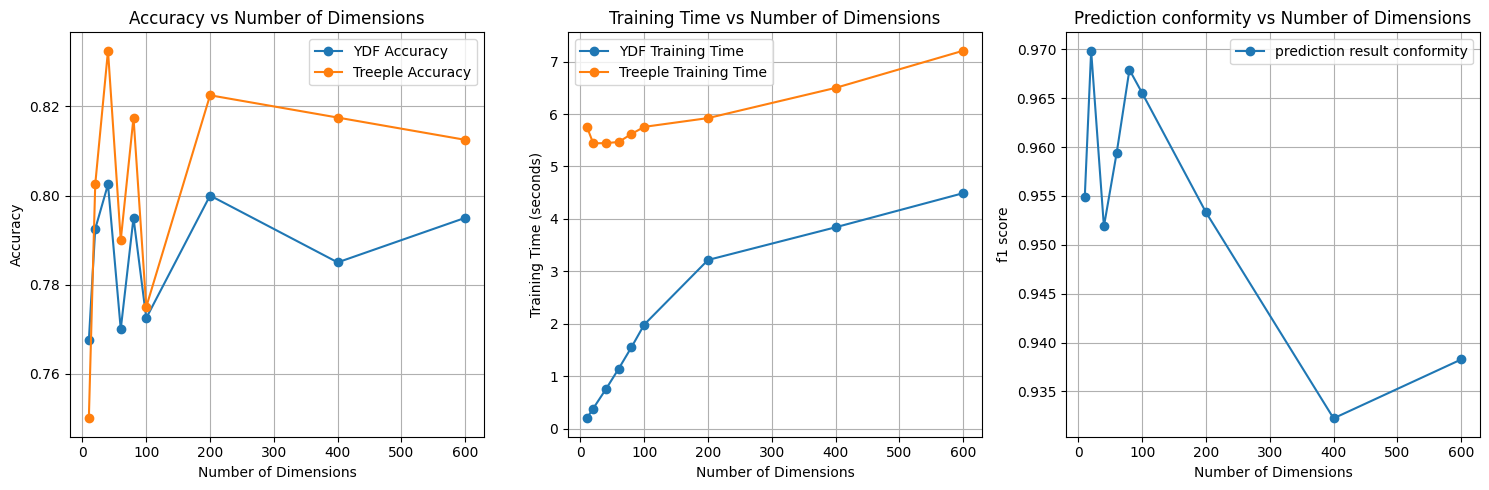

In [95]:
# trunk_simulation(n_tree, num_dims, 
#       n_samples, params_treeple, params_ydf, n_rep=5, plot=True):

MAX_FEATURES = 150
params_ydf1 = params_ydf.copy()
params_ydf1["sparse_oblique_max_num_projections"] = MAX_FEATURES
params_ydf1["sparse_oblique_num_projections_exponent"] = 1.0
params_ydf1["sparse_oblique_projection_density_factor"] = 3.0

params_treeple1 = params_treeple.copy() 
params_treeple1["max_features"] = MAX_FEATURES
params_treeple1["feature_combinations"] = 1.5


n_tree = 500
num_dims = [10, 20, 40, 60, 80, 100, 200, 400, 600]#, 800, 1000, 1500, 2000, 2500, 3000]
n_samples = 2000
accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores2 = trunk_simulation(n_tree, 
                                                                               num_dims, 
                                                                               n_samples, 
                                                                               params_treeple1, 
                                                                               params_ydf1, 
                                                                               n_rep=1, 
                                                                               plot=True)

## simulate two treeple SPORF with same parameter settings but different random states

In [96]:
def trunk_simulation1(n_tree, num_dims, n_samples, params_treeple, n_rep=5, plot=True):
    
    accs_treeple1 = []
    times_treeple1 = []
    accs_treeple = []
    times_treeple = []
    f1_scores = []
    params_treeple1 = params_treeple.copy()  # Copy the original params for treeple
    
    params_treeple1["n_estimators"] = n_tree

    params_treeple2 = params_treeple1.copy()  # Copy the original params for treeple
    params_treeple2["random_state"] = 1

    for num_dim in num_dims:
        print(f"n_dim: {num_dim} | n_tree: {n_tree} | n_samples: {n_samples}")
        

        X, y = make_trunk_classification(n_samples=n_samples, n_dim=num_dim, n_informative=600, seed=0)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        # df_train = prepare_dataframe(X_train, y_train)
        # df_test = prepare_dataframe(X_test, y_test)

        acc_temp_treeple1=0
        time_temp_treeple1=0

        acc_temp_treeple=0
        time_temp_treeple=0

        f1_temp=0

        for _ in range(n_rep):
            # --- Train Treeple1 ---
            treeple_model1 = ObliqueRandomForestClassifier(**params_treeple1)
            acc_treeple1, time_treeple1, pred_treeple1 = train_and_evaluate(treeple_model1, "Treeple", X_train, X_test, y_train, y_test)
            acc_temp_treeple1+=acc_treeple1
            time_temp_treeple1+=time_treeple1
        
            # --- Train Treeple ---
            treeple_model = ObliqueRandomForestClassifier(**params_treeple2)
            acc_treeple, time_treeple, pred_treeple = train_and_evaluate(treeple_model, "Treeple", X_train, X_test, y_train, y_test)
            acc_temp_treeple+=acc_treeple
            time_temp_treeple+=time_treeple

            # Calculate F1 score for two predictions
            f1_compare = f1_score(pred_treeple1, pred_treeple)
            f1_temp+=f1_compare

        accs_treeple1.append(acc_temp_treeple1/n_rep)
        times_treeple1.append(time_temp_treeple1/n_rep)

        accs_treeple.append(acc_temp_treeple/n_rep)
        times_treeple.append(time_temp_treeple/n_rep)

        f1_scores.append(f1_temp/n_rep)
    if plot:
        plot_trunk_simulation(num_dims, accs_treeple1, times_treeple1, 
                                accs_treeple, times_treeple, f1_scores)
    return accs_treeple1, times_treeple1, accs_treeple, times_treeple, f1_scores

n_dim: 10 | n_tree: 500 | n_samples: 2000


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7450, Training Time = 3.3547 sec
Treeple: Accuracy = 0.7525, Training Time = 3.4306 sec
n_dim: 20 | n_tree: 500 | n_samples: 2000


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7775, Training Time = 3.0925 sec
Treeple: Accuracy = 0.7875, Training Time = 3.1295 sec
n_dim: 40 | n_tree: 500 | n_samples: 2000


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 40. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.8300, Training Time = 3.1233 sec
Treeple: Accuracy = 0.8325, Training Time = 3.1435 sec
n_dim: 60 | n_tree: 500 | n_samples: 2000


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 60. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7850, Training Time = 3.0919 sec
Treeple: Accuracy = 0.7925, Training Time = 3.1052 sec
n_dim: 80 | n_tree: 500 | n_samples: 2000


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 80. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.8175, Training Time = 3.2617 sec
Treeple: Accuracy = 0.8125, Training Time = 3.2142 sec
n_dim: 100 | n_tree: 500 | n_samples: 2000


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7750, Training Time = 3.2053 sec
Treeple: Accuracy = 0.7850, Training Time = 3.2283 sec
n_dim: 200 | n_tree: 500 | n_samples: 2000


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.8175, Training Time = 3.4331 sec
Treeple: Accuracy = 0.8250, Training Time = 3.4693 sec
n_dim: 400 | n_tree: 500 | n_samples: 2000


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 400. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.8300, Training Time = 3.8731 sec
Treeple: Accuracy = 0.8200, Training Time = 3.8703 sec
n_dim: 600 | n_tree: 500 | n_samples: 2000
Treeple: Accuracy = 0.8025, Training Time = 4.1809 sec
Treeple: Accuracy = 0.8225, Training Time = 4.2202 sec
n_dim: 800 | n_tree: 500 | n_samples: 2000
Treeple: Accuracy = 0.8200, Training Time = 4.6204 sec
Treeple: Accuracy = 0.8100, Training Time = 4.6079 sec
n_dim: 1000 | n_tree: 500 | n_samples: 2000
Treeple: Accuracy = 0.7875, Training Time = 4.9550 sec
Treeple: Accuracy = 0.7975, Training Time = 4.9592 sec
n_dim: 1500 | n_tree: 500 | n_samples: 2000
Treeple: Accuracy = 0.8175, Training Time = 5.8839 sec
Treeple: Accuracy = 0.8075, Training Time = 5.9051 sec
n_dim: 2000 | n_tree: 500 | n_samples: 2000
Treeple: Accuracy = 0.8100, Training Time = 7.3554 sec
Treeple: Accuracy = 0.7925, Training Time = 7.2419 sec
n_dim: 2500 | n_tree: 500 | n_samples: 2000
Treeple: Accuracy = 0.7950, Training Time = 7.9833 sec
Treeple: Accuracy = 0.7

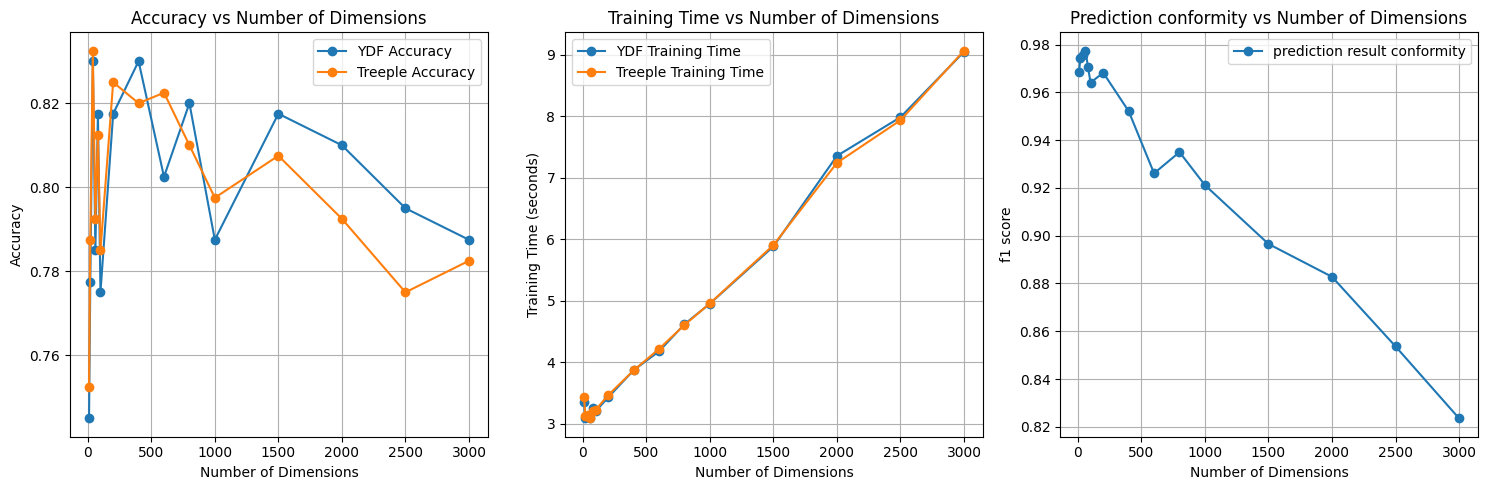

In [84]:
n_tree = 500
num_dims = [10, 20, 40, 60, 80, 100, 200, 400, 600, 800, 1000, 1500, 2000, 2500, 3000]
n_samples = 2000
accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores_standard = trunk_simulation1(n_tree, 
                                                                               num_dims, 
                                                                               n_samples, 
                                                                               params_treeple1,
                                                                               n_rep=1, 
                                                                               plot=True)

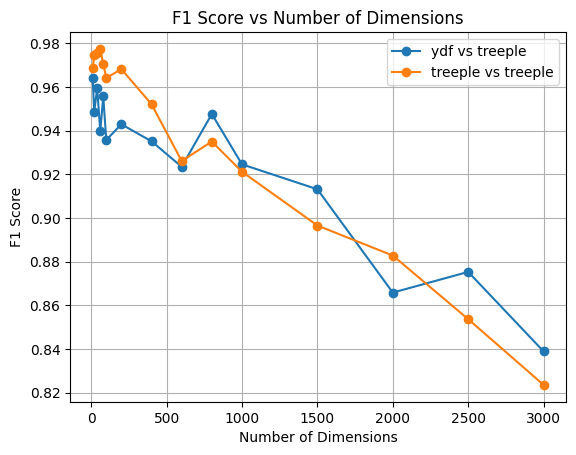

In [88]:
plt.plot(num_dims, f1_scores, label='ydf vs treeple', marker='o')
plt.plot(num_dims, f1_scores_standard, label='treeple vs treeple', marker='o')
plt.xlabel('Number of Dimensions')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Number of Dimensions')
plt.legend()
plt.grid(True)
plt.show()

## Keep the number of trees 10 times of the number of dimensions

In [97]:
def trunk_simulation2(n_tree, num_dims, n_samples, params_treeple, params_ydf, n_rep=5, plot=True):
    #num_dims = [100, 500, 1000, 1500, 2000, 3000, 4000, 10000]
    # num_dims = [5, 10,  20, 50, 100, 200, 400, 600, 800]
    # n_trees = [100, 200, 500, 1000] 
    accs_ydf = []
    times_ydf = []
    accs_treeple = []
    times_treeple = []
    f1_scores = []
    params_treeple1 = params_treeple.copy()  # Copy the original params for treeple
    params_ydf1 = params_ydf.copy()  # Copy the original params for ydf
    

    for i in range(len(num_dims)):
        num_dim = num_dims[i]
        num_tree = n_tree[i]
        
        print(f"n_dim: {num_dim} | n_tree: {n_tree} | n_samples: {n_samples}")
        params_treeple1["n_estimators"] = num_tree
        params_ydf1["num_trees"] = num_tree

        X, y = make_trunk_classification(n_samples=n_samples, n_dim=num_dim, n_informative=600, seed=0)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        df_train = prepare_dataframe(X_train, y_train)
        df_test = prepare_dataframe(X_test, y_test)

        acc_temp_ydf=0
        time_temp_ydf=0

        acc_temp_treeple=0
        time_temp_treeple=0

        f1_temp=0

        for _ in range(n_rep):
            # --- Train YDF ---
            learner = ydf.RandomForestLearner(**params_ydf1)
            start_time = time.time()
            ydf_model = learner.train(df_train)
            time_ydf = time.time() - start_time
            pred_ydf = ydf_model.predict(df_test)
            pred_ydf = (pred_ydf >= 0.5).astype(int) 

            acc_ydf = accuracy_score(y_test, pred_ydf)
            acc_temp_ydf+=acc_ydf
            time_temp_ydf+=time_ydf
        
            # --- Train Treeple ---
            treeple_model = ObliqueRandomForestClassifier(**params_treeple1)
            acc_treeple, time_treeple, pred_treeple = train_and_evaluate(treeple_model, "Treeple", X_train, X_test, y_train, y_test)
            acc_temp_treeple+=acc_treeple
            time_temp_treeple+=time_treeple

            # Calculate F1 score for two predictions
            f1_compare = f1_score(pred_ydf, pred_treeple)
            f1_temp+=f1_compare

        accs_ydf.append(acc_temp_ydf/n_rep)
        times_ydf.append(time_temp_ydf/n_rep)

        accs_treeple.append(acc_temp_treeple/n_rep)
        times_treeple.append(time_temp_treeple/n_rep)

        f1_scores.append(f1_temp/n_rep)
    if plot:
        plot_trunk_simulation(num_dims, accs_ydf, times_ydf, 
                                accs_treeple, times_treeple, f1_scores)
    return accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores

n_dim: 10 | n_tree: [100, 200, 500, 1000, 1500, 2000] | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.045975


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7450, Training Time = 0.7389 sec
n_dim: 20 | n_tree: [100, 200, 500, 1000, 1500, 2000] | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.150999


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7775, Training Time = 1.3042 sec
n_dim: 50 | n_tree: [100, 200, 500, 1000, 1500, 2000] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 50. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.924923
Treeple: Accuracy = 0.8025, Training Time = 3.1351 sec
n_dim: 100 | n_tree: [100, 200, 500, 1000, 1500, 2000] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:03.951154
Treeple: Accuracy = 0.7750, Training Time = 6.5489 sec
n_dim: 150 | n_tree: [100, 200, 500, 1000, 1500, 2000] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 150. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:06.442013
Treeple: Accuracy = 0.8050, Training Time = 10.7119 sec
n_dim: 200 | n_tree: [100, 200, 500, 1000, 1500, 2000] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:09.071753
Treeple: Accuracy = 0.8125, Training Time = 13.6752 sec


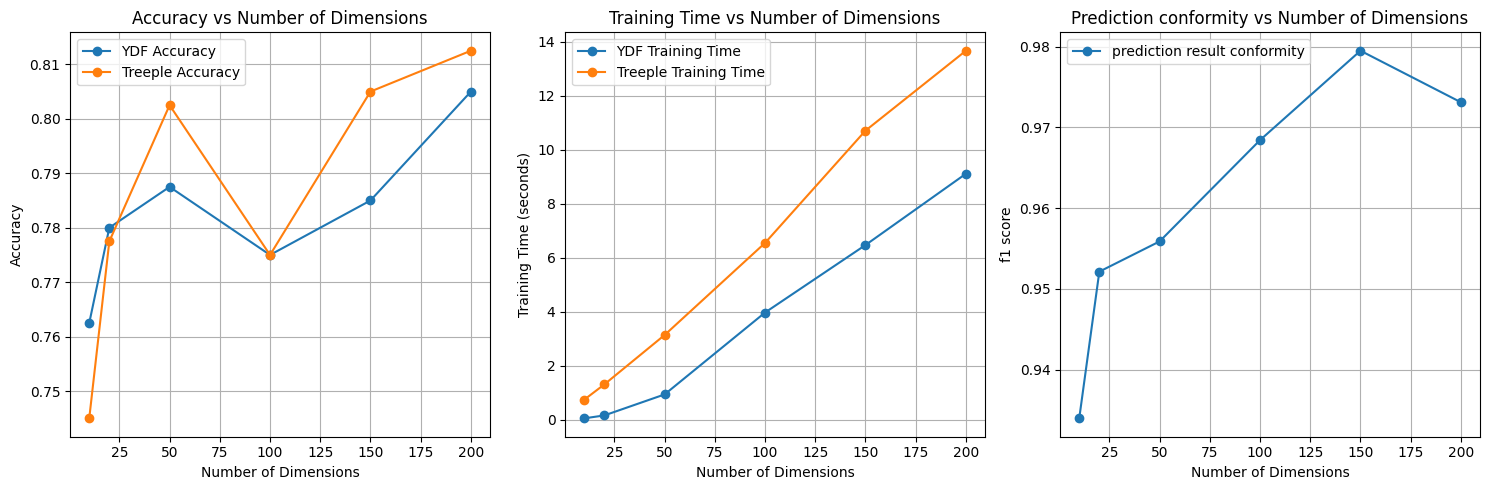

In [107]:
n_tree = [100, 200, 500, 1000, 1500, 2000]
n_dim = [10, 20, 50, 100, 150, 200]
MAX_FEATURES = 100
params_ydf1 = params_ydf.copy()
params_ydf1["sparse_oblique_max_num_projections"] = MAX_FEATURES
params_ydf1["sparse_oblique_num_projections_exponent"] = 1.0
params_ydf1["sparse_oblique_projection_density_factor"] = 3.0

params_treeple1 = params_treeple.copy() 
params_treeple1["max_features"] = MAX_FEATURES
params_treeple1["feature_combinations"] = 1.0
accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores3 = trunk_simulation2(n_tree,
                                                                                 n_dim, 
                                                                                 n_samples, 
                                                                                 params_treeple1,
                                                                                 params_ydf1, 
                                                                                 n_rep=1, 
                                                                                 plot=True)

plot in 3d

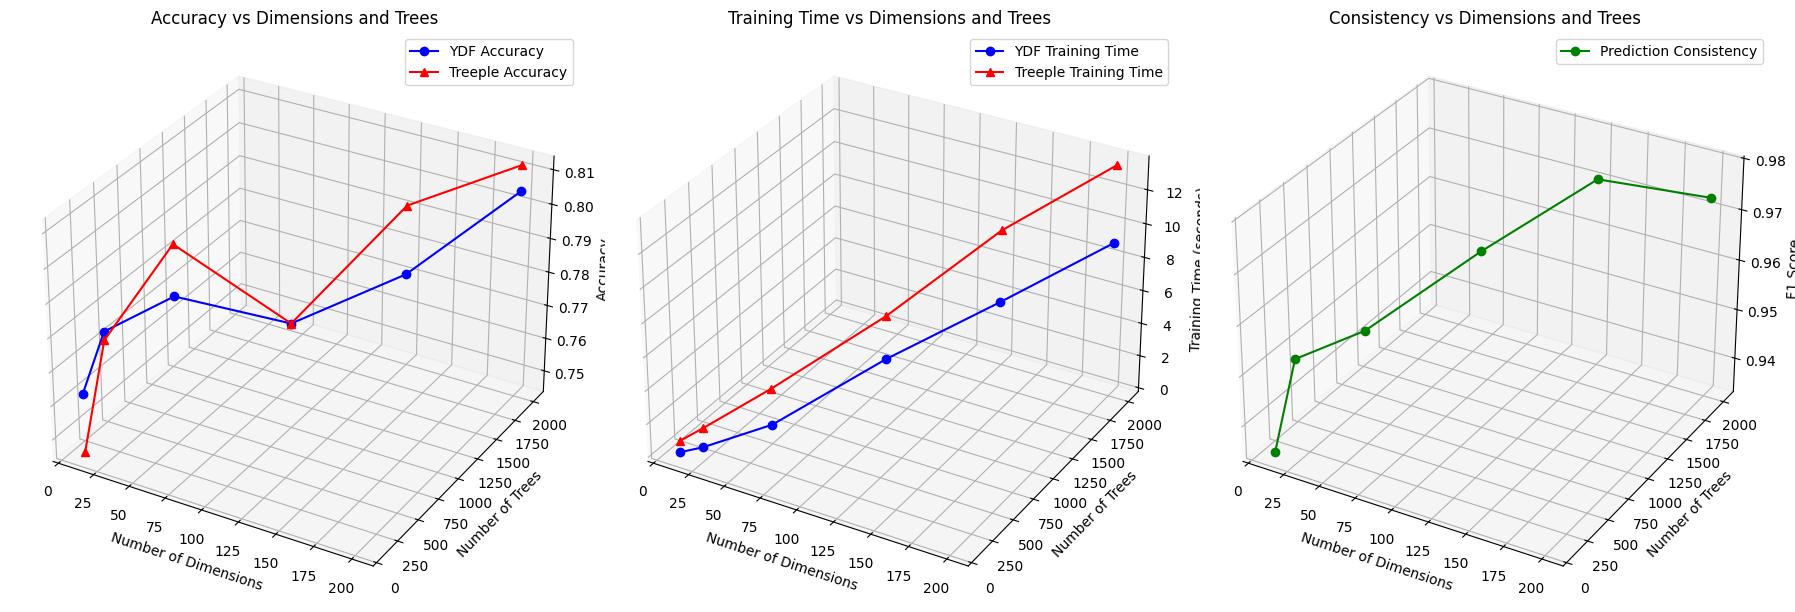

In [109]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d(n_dim, n_tree, accs_ydf, accs_treeple, times_ydf, times_treeple, f1_score3):
    fig = plt.figure(figsize=(18, 6))

    # 3D plot for accuracy
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot3D(n_dim, n_tree, accs_ydf, label='YDF Accuracy', marker='o', color='blue')
    ax1.plot3D(n_dim, n_tree, accs_treeple, label='Treeple Accuracy', marker='^', color='red')
    ax1.set_xlabel('Number of Dimensions')
    ax1.set_ylabel('Number of Trees')
    ax1.set_zlabel('Accuracy')
    ax1.set_title('Accuracy vs Dimensions and Trees')
    ax1.legend()

    # 3D plot for training time
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot3D(n_dim, n_tree, times_ydf, label='YDF Training Time', marker='o', color='blue')
    ax2.plot3D(n_dim, n_tree, times_treeple, label='Treeple Training Time', marker='^', color='red')
    ax2.set_xlabel('Number of Dimensions')
    ax2.set_ylabel('Number of Trees')
    ax2.set_zlabel('Training Time (seconds)')
    ax2.set_title('Training Time vs Dimensions and Trees')
    ax2.legend()

    # 3D plot for consistency (F1 scores)
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.plot3D(n_dim, n_tree, f1_scores3, label='Prediction Consistency', marker='o', color='green')
    ax3.set_xlabel('Number of Dimensions')
    ax3.set_ylabel('Number of Trees')
    ax3.set_zlabel('F1 Score')
    ax3.set_title('Consistency vs Dimensions and Trees')
    ax3.legend()

    plt.tight_layout()
    plt.show()

    
plot_3d(n_dim, n_tree, accs_ydf, accs_treeple, times_ydf, times_treeple, f1_scores3)

trunk simulation with multiple list inputs, simulate two treeple models

In [104]:
def trunk_simulation_treeple3(n_tree, n_dim, n_samples, params_treeple, n_rep=5, plot=True):
    accs_treeple1 = []
    times_treeple1 = []
    accs_treeple2 = []
    times_treeple2 = []
    f1_scores = []

    params_treeple1 = params_treeple.copy()
    params_treeple2 = params_treeple.copy()
    params_treeple2["random_state"] = 1  # Different random state for the second model

    for i in range(len(n_dim)):
        num_dim = n_dim[i]
        num_tree = n_tree[i]

        print(f"n_dim: {num_dim} | n_tree: {num_tree} | n_samples: {n_samples}")
        params_treeple1["n_estimators"] = num_tree
        params_treeple2["n_estimators"] = num_tree

        X, y = make_trunk_classification(n_samples=n_samples, n_dim=num_dim, n_informative=600, seed=0)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        acc_temp_treeple1 = 0
        time_temp_treeple1 = 0
        acc_temp_treeple2 = 0
        time_temp_treeple2 = 0
        f1_temp = 0

        for _ in range(n_rep):
            # Train Treeple model 1
            treeple_model1 = ObliqueRandomForestClassifier(**params_treeple1)
            acc_treeple1, time_treeple1, pred_treeple1 = train_and_evaluate(treeple_model1, "Treeple1", X_train, X_test, y_train, y_test)
            acc_temp_treeple1 += acc_treeple1
            time_temp_treeple1 += time_treeple1

            # Train Treeple model 2
            treeple_model2 = ObliqueRandomForestClassifier(**params_treeple2)
            acc_treeple2, time_treeple2, pred_treeple2 = train_and_evaluate(treeple_model2, "Treeple2", X_train, X_test, y_train, y_test)
            acc_temp_treeple2 += acc_treeple2
            time_temp_treeple2 += time_treeple2

            # Calculate F1 score for predictions
            f1_compare = f1_score(pred_treeple1, pred_treeple2)
            f1_temp += f1_compare

        accs_treeple1.append(acc_temp_treeple1 / n_rep)
        times_treeple1.append(time_temp_treeple1 / n_rep)
        accs_treeple2.append(acc_temp_treeple2 / n_rep)
        times_treeple2.append(time_temp_treeple2 / n_rep)
        f1_scores.append(f1_temp / n_rep)

    if plot:
        plot_trunk_simulation(n_dim, accs_treeple1, times_treeple1, accs_treeple2, times_treeple2, f1_scores)

    return accs_treeple1, times_treeple1, accs_treeple2, times_treeple2, f1_scores


n_dim: 10 | n_tree: [100, 200, 500, 1000, 1500, 2000] | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.063997


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7450, Training Time = 0.7290 sec
n_dim: 20 | n_tree: [100, 200, 500, 1000, 1500, 2000] | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.149995


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7775, Training Time = 1.3296 sec
n_dim: 50 | n_tree: [100, 200, 500, 1000, 1500, 2000] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 50. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.929407
Treeple: Accuracy = 0.8025, Training Time = 3.2250 sec
n_dim: 100 | n_tree: [100, 200, 500, 1000, 1500, 2000] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:04.088002
Treeple: Accuracy = 0.7750, Training Time = 6.6036 sec
n_dim: 150 | n_tree: [100, 200, 500, 1000, 1500, 2000] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 150. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:06.412767
Treeple: Accuracy = 0.8050, Training Time = 10.5301 sec
n_dim: 200 | n_tree: [100, 200, 500, 1000, 1500, 2000] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:08.999957
Treeple: Accuracy = 0.8125, Training Time = 14.4746 sec


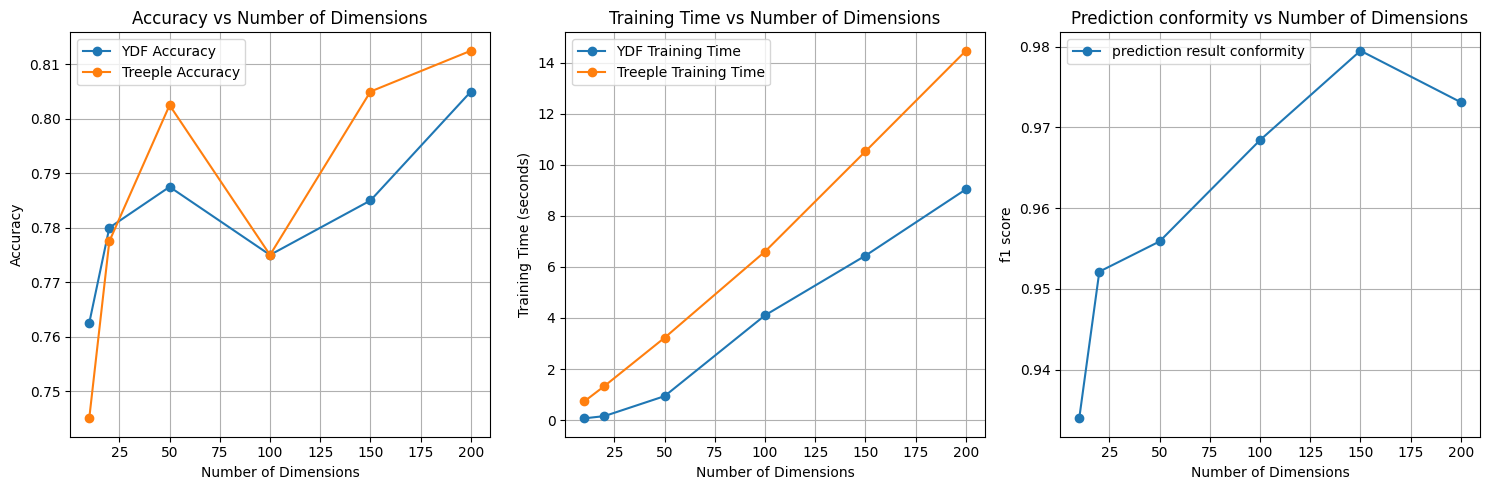

n_dim: 10 | n_tree: 100 | n_samples: 2000
Treeple1: Accuracy = 0.7425, Training Time = 0.1200 sec


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Treeple2: Accuracy = 0.7575, Training Time = 0.1360 sec
n_dim: 20 | n_tree: 200 | n_samples: 2000


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Treeple1: Accuracy = 0.7700, Training Time = 0.3360 sec
Treeple2: Accuracy = 0.7875, Training Time = 0.3560 sec
n_dim: 50 | n_tree: 500 | n_samples: 2000


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 50. Setting n_informative to n_dim.
  warnings.warn(


Treeple1: Accuracy = 0.8000, Training Time = 1.7411 sec
Treeple2: Accuracy = 0.8000, Training Time = 1.7675 sec
n_dim: 100 | n_tree: 1000 | n_samples: 2000


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Treeple1: Accuracy = 0.7750, Training Time = 6.7352 sec
Treeple2: Accuracy = 0.7850, Training Time = 6.6451 sec
n_dim: 150 | n_tree: 1500 | n_samples: 2000


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 150. Setting n_informative to n_dim.
  warnings.warn(


Treeple1: Accuracy = 0.7925, Training Time = 15.0765 sec
Treeple2: Accuracy = 0.7900, Training Time = 15.0976 sec
n_dim: 200 | n_tree: 2000 | n_samples: 2000


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Treeple1: Accuracy = 0.8100, Training Time = 26.2771 sec
Treeple2: Accuracy = 0.8075, Training Time = 26.1469 sec


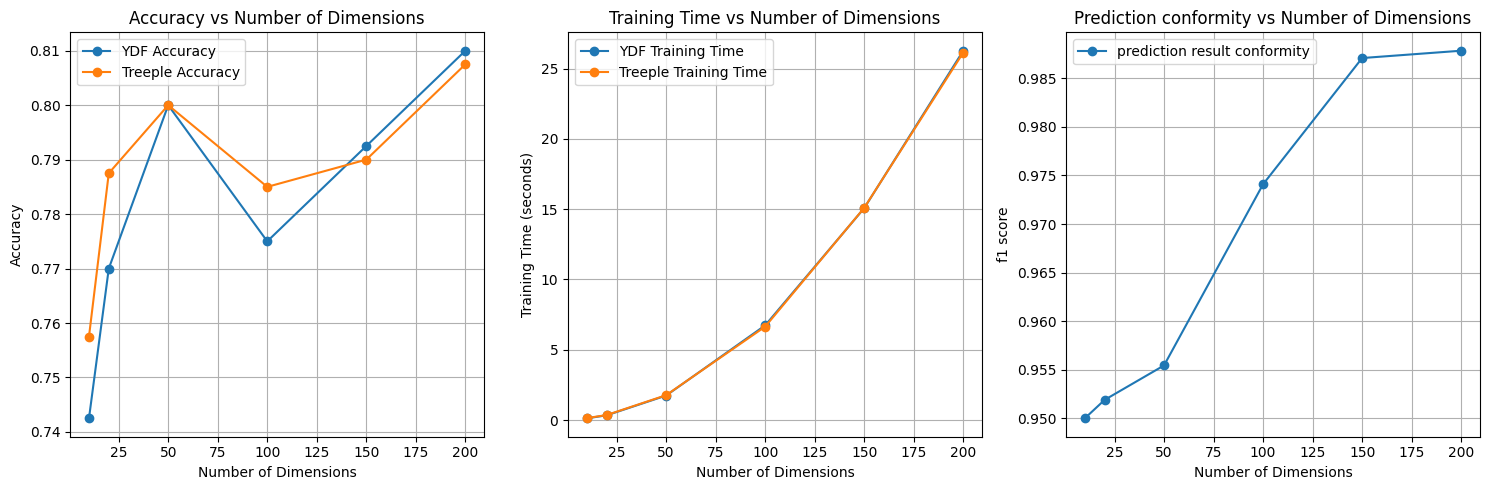

In [106]:

n_tree = [100, 200, 500, 1000, 1500, 2000]
n_dim = [10, 20, 50, 100, 150, 200]
MAX_FEATURES = 100
params_ydf1 = params_ydf.copy()
params_ydf1["sparse_oblique_max_num_projections"] = MAX_FEATURES
params_ydf1["sparse_oblique_num_projections_exponent"] = 1.0
params_ydf1["sparse_oblique_projection_density_factor"] = 3.0

params_treeple1 = params_treeple.copy() 
params_treeple1["max_features"] = MAX_FEATURES
params_treeple1["feature_combinations"] = 1.0
accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores3 = trunk_simulation2(n_tree,
                                                                                 n_dim, 
                                                                                 n_samples, 
                                                                                 params_treeple1,
                                                                                 params_ydf1, 
                                                                                 n_rep=1, 
                                                                                 plot=True)
accs_treeple1, times_treeple1, accs_treeple2, times_treeple2, f1_scores_standard1 = trunk_simulation_treeple3(n_tree, n_dim, n_samples, params_treeple, n_rep=1, plot=True)

# Compare and plot confusion matrices

In [ ]:
for i in range(len(n_tree)):
    conf_matrix_title = f"Confusion Matrix (n_tree={n_tree[i]}, n_dim={n_dim[i]})"
    print(conf_matrix_title)
    conf_matrix = compare_confusion_matrix(n_tree[i], n_dim[i], n_samples, params_treeple1, params_ydf1)
    
    disp_treeple = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp_treeple.plot()
    plt.title("Confusion Matrix for Treeple Predictions vs YDF Predictions")
    plt.xlabel("treeple_pred")
    plt.ylabel("YDF_pred")
    plt.show()

Confusion Matrix (n_tree=100, n_dim=10)


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7450, Training Time = 0.7649 sec
Train model on 1600 examples
Model trained in 0:00:00.043002
YDF | n_dim: 10 | n_tree: 100 | Accuracy: 0.7625 | Train Time: 0.0440 sec
Confusion Matrix for YDF Predictions:
[[182  16]
 [ 11 191]]
Confusion Matrix (n_tree=200, n_dim=20)


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7775, Training Time = 1.2739 sec
Train model on 1600 examples
Model trained in 0:00:00.148996
YDF | n_dim: 20 | n_tree: 200 | Accuracy: 0.7800 | Train Time: 0.1510 sec
Confusion Matrix for YDF Predictions:
[[192   9]
 [ 10 189]]
Confusion Matrix (n_tree=500, n_dim=50)


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 50. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.8025, Training Time = 3.0860 sec
Train model on 1600 examples
Model trained in 0:00:00.918437
YDF | n_dim: 50 | n_tree: 500 | Accuracy: 0.7875 | Train Time: 0.9224 sec
Confusion Matrix for YDF Predictions:
[[187   6]
 [ 12 195]]
Confusion Matrix (n_tree=1000, n_dim=100)


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7750, Training Time = 6.5534 sec
Train model on 1600 examples
Model trained in 0:00:03.978086
YDF | n_dim: 100 | n_tree: 1000 | Accuracy: 0.7750 | Train Time: 3.9821 sec
Confusion Matrix for YDF Predictions:
[[204   4]
 [  8 184]]
Confusion Matrix (n_tree=1500, n_dim=150)


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 150. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.8050, Training Time = 10.5260 sec
Train model on 1600 examples
Model trained in 0:00:06.588713
YDF | n_dim: 150 | n_tree: 1500 | Accuracy: 0.7850 | Train Time: 6.5937 sec
Confusion Matrix for YDF Predictions:
[[201   3]
 [  5 191]]
Confusion Matrix (n_tree=2000, n_dim=200)


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.8125, Training Time = 13.6462 sec
Train model on 1600 examples
Model trained in 0:00:08.607720
YDF | n_dim: 200 | n_tree: 2000 | Accuracy: 0.8050 | Train Time: 8.6137 sec
Confusion Matrix for YDF Predictions:
[[190   3]
 [  8 199]]


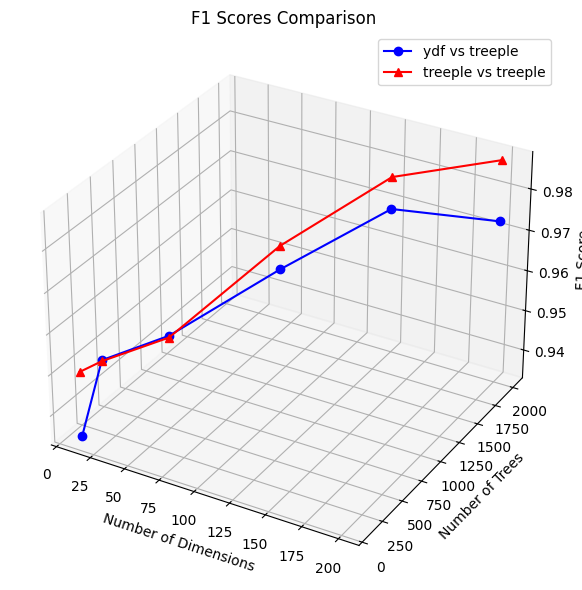

In [111]:
def plot_3d_comparison(n_dim, n_tree, f1_scores3, f1_scores_standard1):
    fig = plt.figure(figsize=(10, 6))

    # 3D plot for F1 scores comparison
    ax = fig.add_subplot(111, projection='3d')
    ax.plot3D(n_dim, n_tree, f1_scores3, label='ydf vs treeple', marker='o', color='blue')
    ax.plot3D(n_dim, n_tree, f1_scores_standard1, label='treeple vs treeple', marker='^', color='red')
    ax.set_xlabel('Number of Dimensions')
    ax.set_ylabel('Number of Trees')
    ax.set_zlabel('F1 Score')
    ax.set_title('F1 Scores Comparison')
    ax.legend()

    plt.tight_layout()
    plt.show()

plot_3d_comparison(n_dim, n_tree, f1_scores3, f1_scores_standard1)

c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7450, Training Time = 0.7548 sec
Train model on 1600 examples
Model trained in 0:00:00.043000
YDF | n_dim: 10 | n_tree: 100 | Accuracy: 0.7625 | Train Time: 0.0440 sec
Confusion Matrix for YDF Predictions:
[[182  16]
 [ 11 191]]


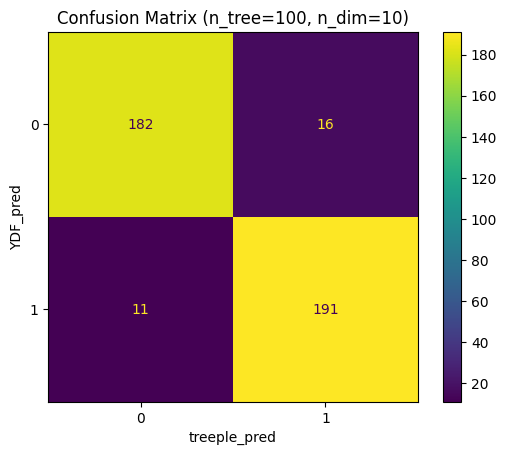

c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7775, Training Time = 1.2829 sec
Train model on 1600 examples
Model trained in 0:00:00.149996
YDF | n_dim: 20 | n_tree: 200 | Accuracy: 0.7800 | Train Time: 0.1520 sec
Confusion Matrix for YDF Predictions:
[[192   9]
 [ 10 189]]


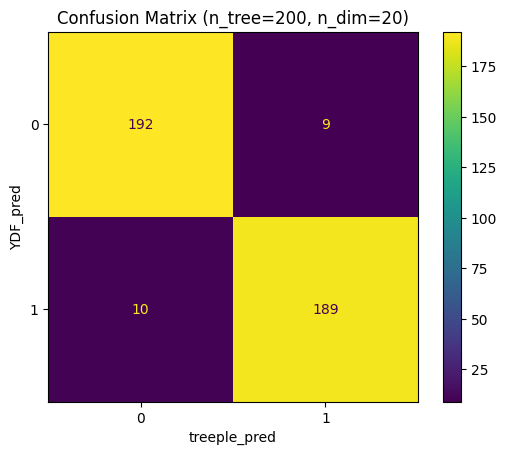

c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 50. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.8025, Training Time = 3.1001 sec
Train model on 1600 examples
Model trained in 0:00:00.978187
YDF | n_dim: 50 | n_tree: 500 | Accuracy: 0.7875 | Train Time: 0.9812 sec
Confusion Matrix for YDF Predictions:
[[187   6]
 [ 12 195]]


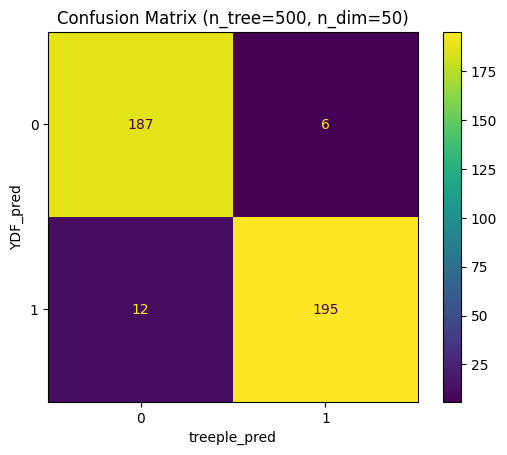

c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7750, Training Time = 6.7669 sec
Train model on 1600 examples
Model trained in 0:00:04.043749
YDF | n_dim: 100 | n_tree: 1000 | Accuracy: 0.7750 | Train Time: 4.0508 sec
Confusion Matrix for YDF Predictions:
[[204   4]
 [  8 184]]


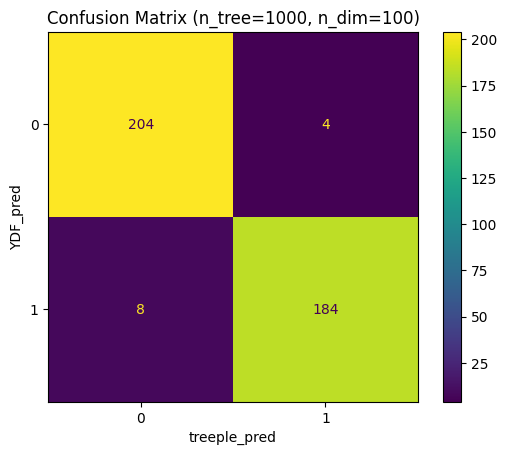

c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 150. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.8050, Training Time = 10.1674 sec
Train model on 1600 examples
Model trained in 0:00:06.346114
YDF | n_dim: 150 | n_tree: 1500 | Accuracy: 0.7850 | Train Time: 6.3531 sec
Confusion Matrix for YDF Predictions:
[[201   3]
 [  5 191]]


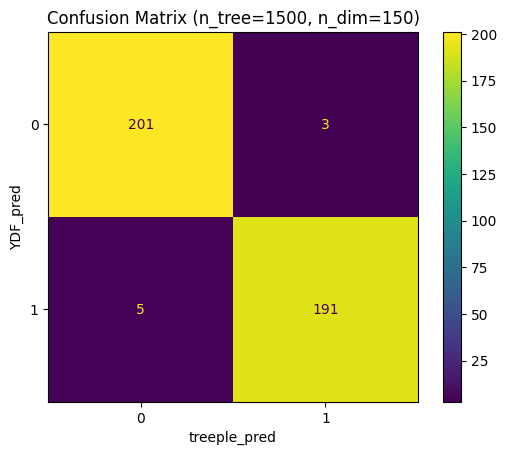

c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.8125, Training Time = 14.1232 sec
Train model on 1600 examples
Model trained in 0:00:08.705280
YDF | n_dim: 200 | n_tree: 2000 | Accuracy: 0.8050 | Train Time: 8.7133 sec
Confusion Matrix for YDF Predictions:
[[190   3]
 [  8 199]]


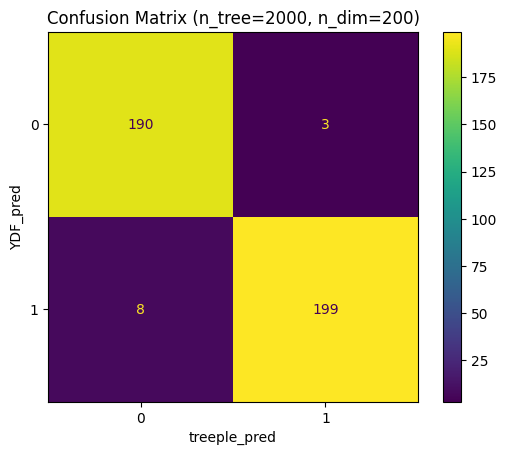

In [117]:
for i in range(len(n_tree)):
    conf_matrix_title = f"Confusion Matrix (n_tree={n_tree[i]}, n_dim={n_dim[i]})"
    #print(conf_matrix_title)
    _, conf_matrix = compare_confusion_matrix(n_tree[i], n_dim[i], n_samples, params_treeple1, params_ydf1)
    
    disp_treeple = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp_treeple.plot()
    plt.title(conf_matrix_title)
    plt.xlabel("treeple_pred")
    plt.ylabel("YDF_pred")
    plt.show()

# honest RF

In [127]:
from treeple import HonestForestClassifier

model_treeple = HonestForestClassifier(
    n_estimators=100,
    criterion="gini",
    splitter="best",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    bootstrap=True,
    honest_fraction=0.5,
    honest_method="apply",  # or "prune"
    honest_prior="ignore",  # corresponds to how missing leaves are handled
    random_state=42,
    n_jobs=-1
)


In [128]:
def trunk_simulation_honest(n_tree, num_dims, n_samples, params_treeple, params_ydf, n_rep=5, plot=True):
    #num_dims = [100, 500, 1000, 1500, 2000, 3000, 4000, 10000]
    # num_dims = [5, 10,  20, 50, 100, 200, 400, 600, 800]
    # n_trees = [100, 200, 500, 1000] 
    accs_ydf = []
    times_ydf = []
    accs_treeple = []
    times_treeple = []
    f1_scores = []
    params_treeple1 = params_treeple.copy()  # Copy the original params for treeple
    params_ydf1 = params_ydf.copy()  # Copy the original params for ydf
    params_treeple1["n_estimators"] = n_tree
    params_ydf1["num_trees"] = n_tree

    for num_dim in num_dims:
        print(f"n_dim: {num_dim} | n_tree: {n_tree} | n_samples: {n_samples}")
        

        X, y = make_trunk_classification(n_samples=n_samples, n_dim=num_dim, n_informative=600, seed=0)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        df_train = prepare_dataframe(X_train, y_train)
        df_test = prepare_dataframe(X_test, y_test)

        acc_temp_ydf=0
        time_temp_ydf=0

        acc_temp_treeple=0
        time_temp_treeple=0

        f1_temp=0

        for _ in range(n_rep):
            # --- Train YDF ---
            learner = ydf.RandomForestLearner(**params_ydf1)
            start_time = time.time()
            ydf_model = learner.train(df_train)
            time_ydf = time.time() - start_time
            pred_ydf = ydf_model.predict(df_test)
            pred_ydf = (pred_ydf >= 0.5).astype(int) 

            acc_ydf = accuracy_score(y_test, pred_ydf)
            acc_temp_ydf+=acc_ydf
            time_temp_ydf+=time_ydf
        
            # --- Train Treeple ---
            treeple_model = HonestForestClassifier(**params_treeple1)
            acc_treeple, time_treeple, pred_treeple = train_and_evaluate(treeple_model, "Treeple", X_train, X_test, y_train, y_test)
            acc_temp_treeple+=acc_treeple
            time_temp_treeple+=time_treeple

            # Calculate F1 score for two predictions
            f1_compare = f1_score(pred_ydf, pred_treeple)
            f1_temp+=f1_compare

        accs_ydf.append(acc_temp_ydf/n_rep)
        times_ydf.append(time_temp_ydf/n_rep)

        accs_treeple.append(acc_temp_treeple/n_rep)
        times_treeple.append(time_temp_treeple/n_rep)

        f1_scores.append(f1_temp/n_rep)
    if plot:
        plot_trunk_simulation(num_dims, accs_ydf, times_ydf, 
                                accs_treeple, times_treeple, f1_scores)
    return accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores

In [ ]:
params_treeple_honest = {
    "n_estimators": 100,
    "criterion": "gini",
    "splitter": "best",
    "max_depth": 15,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "max_features": "sqrt",
    "bootstrap": True,
    "honest_fraction": 0.5,
    "honest_method": "apply",
    "honest_prior": "ignore",
    "random_state": 42,
    "n_jobs": -1
}


In [ ]:
params_ydf_honest = {
    "label": "target",
    "num_trees": 100,
    "bootstrap_training_dataset": True,  # Equivalent to Treeple's bootstrap=True
    "sampling_with_replacement": True,   # Ensures bootstrapped samples
    "bootstrap_size_ratio": 1.0,         # Full bootstrap sample like Treeple
    "honest": True,                      # Enable honesty
    "honest_ratio_leaf_examples": 0.5,   # 50% for structure, 50% for leaves
    "honest_fixed_separation": False,    # Use different separation per tree (matches Treeple)
    "max_depth": 15,                     # No max depth
    "min_examples": 2,                   # Equivalent to min_samples_split=2
    "num_candidate_attributes_ratio": 0.5,  # sqrt(n_features), typical RF setting
    "growing_strategy": "LOCAL",         # Classic greedy split
    "random_seed": 42,
}


n_dim: 10 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.081514


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7525, Training Time = 6.8431 sec
n_dim: 20 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.113017


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7775, Training Time = 6.9141 sec
n_dim: 50 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 50. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.210817
Treeple: Accuracy = 0.7800, Training Time = 6.8490 sec
n_dim: 100 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.392655
Treeple: Accuracy = 0.7775, Training Time = 7.0087 sec
n_dim: 150 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 150. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.614425
Treeple: Accuracy = 0.7925, Training Time = 6.8123 sec
n_dim: 200 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.742214
Treeple: Accuracy = 0.8150, Training Time = 6.8277 sec
n_dim: 400 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 400. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.462098
Treeple: Accuracy = 0.8125, Training Time = 6.7692 sec
n_dim: 600 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:02.115933
Treeple: Accuracy = 0.7750, Training Time = 6.6746 sec
n_dim: 800 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:02.941516
Treeple: Accuracy = 0.7925, Training Time = 6.4891 sec
n_dim: 1000 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:03.552529
Treeple: Accuracy = 0.7850, Training Time = 6.6920 sec


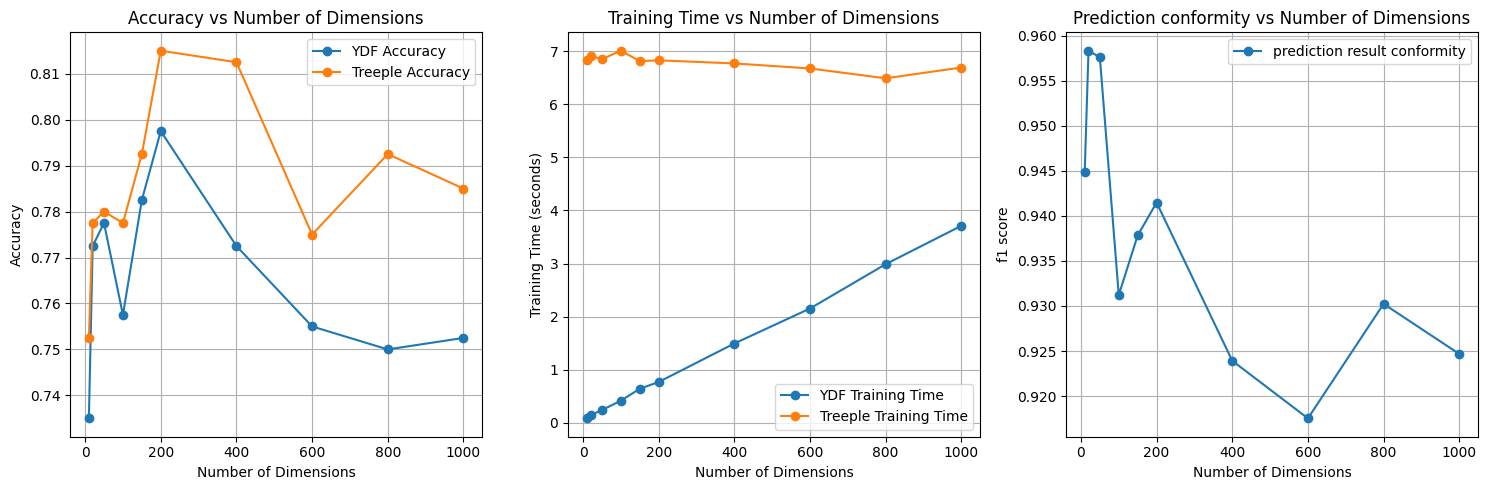

([0.735, 0.7725, 0.7775, 0.7575, 0.7825, 0.7975, 0.7725, 0.755, 0.75, 0.7525],
 [0.08351397514343262,
  0.14401459693908691,
  0.2393336296081543,
  0.41565752029418945,
  0.6404247283935547,
  0.7682173252105713,
  1.4930942058563232,
  2.1524438858032227,
  2.987513542175293,
  3.7105555534362793],
 [0.7525, 0.7775, 0.78, 0.7775, 0.7925, 0.815, 0.8125, 0.775, 0.7925, 0.785],
 [6.84310507774353,
  6.9141106605529785,
  6.848964691162109,
  7.008654356002808,
  6.812276601791382,
  6.827722072601318,
  6.769165277481079,
  6.674569606781006,
  6.489111661911011,
  6.692002534866333],
 [0.9448818897637795,
  0.9583333333333334,
  0.9576059850374065,
  0.9312169312169312,
  0.9378238341968912,
  0.9414758269720102,
  0.9239130434782609,
  0.9175257731958762,
  0.9302325581395349,
  0.9246753246753247])

In [131]:

n_tree = 500
num_dims = [10, 20, 50, 100, 150, 200, 400, 600, 800, 1000]
n_samples = 2000

trunk_simulation_honest(n_tree, num_dims, n_samples, params_treeple_honest, params_ydf_honest, n_rep=1, plot=True)

In [132]:
params_ydf_honest

{'label': 'target',
 'num_trees': 100,
 'bootstrap_training_dataset': True,
 'sampling_with_replacement': True,
 'bootstrap_size_ratio': 1.0,
 'honest': True,
 'honest_ratio_leaf_examples': 0.5,
 'honest_fixed_separation': False,
 'max_depth': -1,
 'min_examples': 2,
 'num_candidate_attributes_ratio': 0.5,
 'growing_strategy': 'LOCAL',
 'random_seed': 42}

In [134]:
params_treeple_honest

{'n_estimators': 100,
 'criterion': 'gini',
 'splitter': 'best',
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'bootstrap': True,
 'honest_fraction': 0.5,
 'honest_method': 'apply',
 'honest_prior': 'ignore',
 'random_state': 42,
 'n_jobs': -1}

n_dim: 10 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.089000


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7400, Training Time = 6.5362 sec
n_dim: 20 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.109508


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7575, Training Time = 6.5696 sec
n_dim: 50 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 50. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.212013
Treeple: Accuracy = 0.7475, Training Time = 6.7063 sec
n_dim: 100 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.390624
Treeple: Accuracy = 0.7300, Training Time = 7.2845 sec
n_dim: 150 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 150. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.655060
Treeple: Accuracy = 0.7400, Training Time = 7.1093 sec
n_dim: 200 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.770820
Treeple: Accuracy = 0.7550, Training Time = 7.2447 sec
n_dim: 400 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 400. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.515752
Treeple: Accuracy = 0.7200, Training Time = 7.9740 sec
n_dim: 600 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:02.153945
Treeple: Accuracy = 0.7200, Training Time = 8.7278 sec
n_dim: 800 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:02.965101
Treeple: Accuracy = 0.7275, Training Time = 9.4340 sec
n_dim: 1000 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:03.660673
Treeple: Accuracy = 0.7350, Training Time = 10.2669 sec


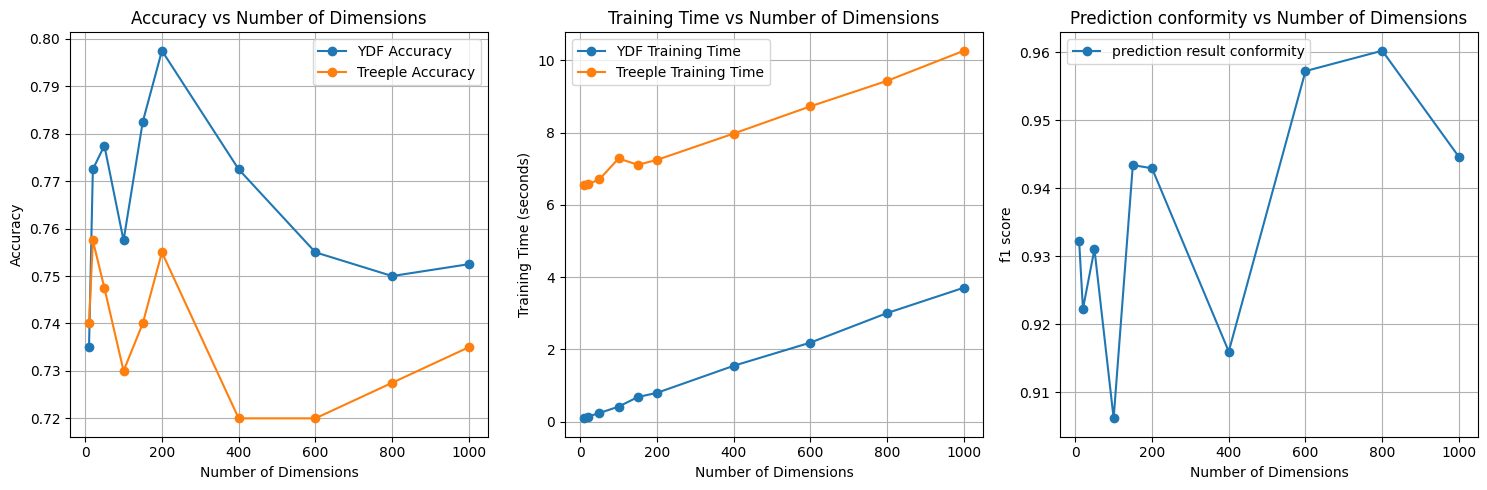

([0.735, 0.7725, 0.7775, 0.7575, 0.7825, 0.7975, 0.7725, 0.755, 0.75, 0.7525],
 [0.09099912643432617,
  0.14050698280334473,
  0.23752188682556152,
  0.41562461853027344,
  0.6802456378936768,
  0.7968199253082275,
  1.545750379562378,
  2.18795108795166,
  3.0061018466949463,
  3.7076752185821533],
 [0.74, 0.7575, 0.7475, 0.73, 0.74, 0.755, 0.72, 0.72, 0.7275, 0.735],
 [6.536203145980835,
  6.569637060165405,
  6.706276893615723,
  7.284460067749023,
  7.109256982803345,
  7.244693756103516,
  7.973991394042969,
  8.727763891220093,
  9.43400526046753,
  10.266912698745728],
 [0.9322916666666666,
  0.9222797927461139,
  0.9310344827586207,
  0.9061662198391421,
  0.9433962264150944,
  0.9429280397022333,
  0.9159891598915989,
  0.9572192513368984,
  0.9602122015915119,
  0.9445910290237467])

In [137]:
params_ydf_honest['num_candidate_attributes_ratio'] = 0.5
params_treeple_honest['max_features'] = 0.5
params_treeple_honest['honest_method'] = 'apply'


trunk_simulation_honest(n_tree, num_dims, n_samples, params_treeple_honest, params_ydf_honest, n_rep=1, plot=True)

n_dim: 10 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.088510


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7400, Training Time = 6.7849 sec
n_dim: 20 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.112500


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7575, Training Time = 8.0022 sec
n_dim: 50 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 50. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.231013
Treeple: Accuracy = 0.7475, Training Time = 8.6301 sec
n_dim: 100 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.412159
Treeple: Accuracy = 0.7300, Training Time = 8.7733 sec
n_dim: 150 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 150. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.611606
Treeple: Accuracy = 0.7400, Training Time = 8.7119 sec
n_dim: 200 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.744063
Treeple: Accuracy = 0.7550, Training Time = 8.8338 sec
n_dim: 400 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 400. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.516207
Treeple: Accuracy = 0.7200, Training Time = 8.8873 sec
n_dim: 600 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:02.295393
Treeple: Accuracy = 0.7200, Training Time = 9.3376 sec
n_dim: 800 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:03.034650
Treeple: Accuracy = 0.7275, Training Time = 9.7607 sec
n_dim: 1000 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:03.800168
Treeple: Accuracy = 0.7350, Training Time = 11.3233 sec
n_dim: 1300 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:05.347856
Treeple: Accuracy = 0.7250, Training Time = 12.9617 sec
n_dim: 1600 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:05.876662
Treeple: Accuracy = 0.7250, Training Time = 15.9145 sec
n_dim: 2000 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:07.465645
Treeple

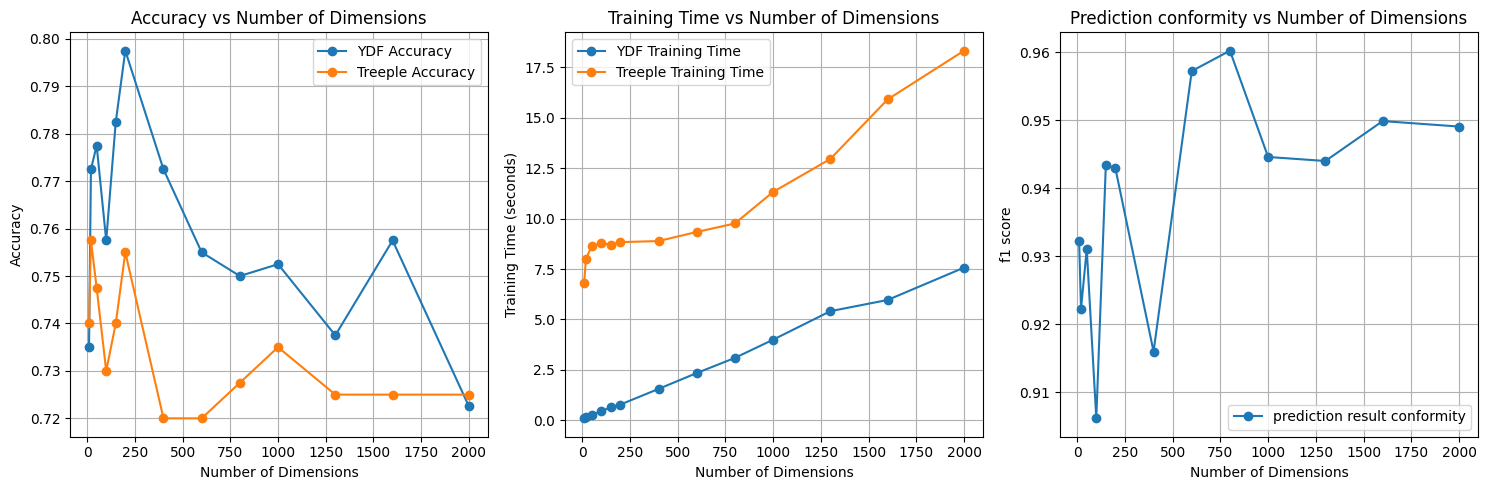

([0.735,
  0.7725,
  0.7775,
  0.7575,
  0.7825,
  0.7975,
  0.7725,
  0.755,
  0.75,
  0.7525,
  0.7375,
  0.7575,
  0.7225],
 [0.09151101112365723,
  0.1440114974975586,
  0.2625246047973633,
  0.43915796279907227,
  0.6436367034912109,
  0.7750647068023682,
  1.5512120723724365,
  2.3383915424346924,
  3.089968681335449,
  3.993189573287964,
  5.408366441726685,
  5.9643073081970215,
  7.569159269332886],
 [0.74,
  0.7575,
  0.7475,
  0.73,
  0.74,
  0.755,
  0.72,
  0.72,
  0.7275,
  0.735,
  0.725,
  0.725,
  0.725],
 [6.7849133014678955,
  8.002245664596558,
  8.630096912384033,
  8.77334213256836,
  8.71188473701477,
  8.833777666091919,
  8.887303352355957,
  9.337578296661377,
  9.760727882385254,
  11.323302030563354,
  12.961731672286987,
  15.91445541381836,
  18.330936193466187],
 [0.9322916666666666,
  0.9222797927461139,
  0.9310344827586207,
  0.9061662198391421,
  0.9433962264150944,
  0.9429280397022333,
  0.9159891598915989,
  0.9572192513368984,
  0.9602122015915119

In [138]:

num_dims = [10, 20, 50, 100, 150, 200, 400, 600, 800, 1000, 1300, 1600, 2000]
trunk_simulation_honest(n_tree, num_dims, n_samples, params_treeple_honest, params_ydf_honest, n_rep=1, plot=True)

In [11]:
params_ydf1

{'label': 'target',
 'max_depth': 10,
 'num_trees': 1000,
 'random_seed': 42,
 'honest': False,
 'bootstrap_size_ratio': 1.0,
 'bootstrap_training_dataset': True,
 'categorical_algorithm': 'ONE_HOT',
 'split_axis': 'SPARSE_OBLIQUE',
 'compute_oob_performances': False,
 'compute_oob_variable_importances': False,
 'max_num_nodes': None,
 'growing_strategy': 'BEST_FIRST_GLOBAL',
 'num_candidate_attributes': 1,
 'sorting_strategy': 'IN_NODE',
 'sparse_oblique_weights': 'CONTINUOUS',
 'sparse_oblique_projection_density_factor': 1.0,
 'sparse_oblique_normalization': 'MIN_MAX',
 'sparse_oblique_max_num_projections': 100,
 'sparse_oblique_num_projections_exponent': 1.0,
 'sampling_with_replacement': False}

In [12]:
params_treeple1

{'n_estimators': 1000,
 'criterion': 'entropy',
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': 100,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'bootstrap': True,
 'oob_score': False,
 'n_jobs': -1,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False,
 'class_weight': None,
 'max_samples': None,
 'feature_combinations': 1.0}

n_dim: 10 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.220252
Treeple: Accuracy = 0.7450, Training Time = 3.7541 sec
Train model on 1600 examples
Model trained in 0:00:00.188652
Treeple: Accuracy = 0.7450, Training Time = 3.5297 sec
Train model on 1600 examples
Model trained in 0:00:00.208775
Treeple: Accuracy = 0.7450, Training Time = 3.4750 sec
n_dim: 20 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.394583
Treeple: Accuracy = 0.7775, Training Time = 3.5366 sec
Train model on 1600 examples
Model trained in 0:00:00.408002
Treeple: Accuracy = 0.7775, Training Time = 3.4973 sec
Train model on 1600 examples
Model trained in 0:00:00.364619
Treeple: Accuracy = 0.7775, Training Time = 3.4741 sec
n_dim: 40 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 40. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.756267
Treeple: Accuracy = 0.8300, Training Time = 3.4837 sec
Train model on 1600 examples
Model trained in 0:00:00.784772
Treeple: Accuracy = 0.8300, Training Time = 3.3495 sec
Train model on 1600 examples
Model trained in 0:00:00.757082
Treeple: Accuracy = 0.8300, Training Time = 3.4215 sec
n_dim: 60 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 60. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.211716
Treeple: Accuracy = 0.7850, Training Time = 3.4848 sec
Train model on 1600 examples
Model trained in 0:00:01.206233
Treeple: Accuracy = 0.7850, Training Time = 3.4528 sec
Train model on 1600 examples
Model trained in 0:00:01.234201
Treeple: Accuracy = 0.7850, Training Time = 3.4682 sec
n_dim: 80 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 80. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.752637
Treeple: Accuracy = 0.8175, Training Time = 3.6635 sec
Train model on 1600 examples
Model trained in 0:00:01.644999
Treeple: Accuracy = 0.8175, Training Time = 3.4611 sec
Train model on 1600 examples
Model trained in 0:00:01.554557
Treeple: Accuracy = 0.8175, Training Time = 3.4387 sec
n_dim: 100 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:02.070731
Treeple: Accuracy = 0.7750, Training Time = 3.4987 sec
Train model on 1600 examples
Model trained in 0:00:01.952845
Treeple: Accuracy = 0.7750, Training Time = 3.5392 sec
Train model on 1600 examples
Model trained in 0:00:01.975488
Treeple: Accuracy = 0.7750, Training Time = 3.4401 sec
n_dim: 200 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:02.256264
Treeple: Accuracy = 0.8175, Training Time = 3.6592 sec
Train model on 1600 examples
Model trained in 0:00:02.202219
Treeple: Accuracy = 0.8175, Training Time = 3.7622 sec
Train model on 1600 examples
Model trained in 0:00:02.191361
Treeple: Accuracy = 0.8175, Training Time = 3.6091 sec
n_dim: 400 | n_tree: 500 | n_samples: 2000


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 400. Setting n_informative to n_dim.
  warnings.warn(


Train model on 1600 examples
Model trained in 0:00:02.599925
Treeple: Accuracy = 0.8300, Training Time = 4.0859 sec
Train model on 1600 examples
Model trained in 0:00:02.607853
Treeple: Accuracy = 0.8300, Training Time = 4.1297 sec
Train model on 1600 examples
Model trained in 0:00:02.581815
Treeple: Accuracy = 0.8300, Training Time = 4.1809 sec
n_dim: 600 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:03.126824
Treeple: Accuracy = 0.8025, Training Time = 4.6610 sec
Train model on 1600 examples
Model trained in 0:00:03.079804
Treeple: Accuracy = 0.8025, Training Time = 4.4568 sec
Train model on 1600 examples
Model trained in 0:00:02.986336
Treeple: Accuracy = 0.8025, Training Time = 4.4614 sec
n_dim: 800 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:03.381275
Treeple: Accuracy = 0.8200, Training Time = 4.8015 sec
Train model on 1600 examples
Model trained in 0:00:03.542182
Treeple: Accuracy = 0.8200, Training Time

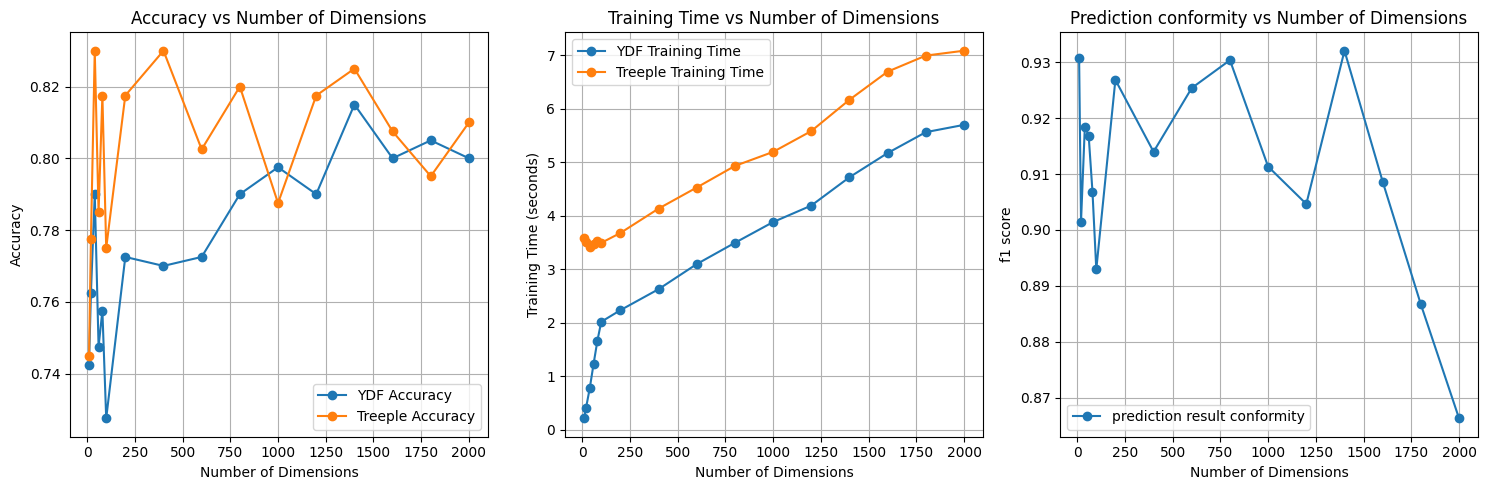

In [10]:
# trunk_simulation(n_tree, num_dims, 
#       n_samples, params_treeple, params_ydf, n_rep=5, plot=True):


params_ydf1 = params_ydf.copy()
params_ydf1["sparse_oblique_max_num_projections"] = 100

params_treeple1 = params_treeple.copy() 
params_treeple1["max_features"] = 100



n_tree = 500
num_dims = [10, 20, 40, 60, 80, 100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
n_samples = 2000
accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores = trunk_simulation(n_tree, 
                                                                               num_dims, 
                                                                               n_samples, 
                                                                               params_treeple1, 
                                                                               params_ydf1, 
                                                                               n_rep=3, 
                                                                               plot=True)

## modify max node treeple(4/15 update)

n_dim: 10 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.198151


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7575, Training Time = 2.8328 sec
Train model on 1600 examples
Model trained in 0:00:00.182118
Treeple: Accuracy = 0.7575, Training Time = 2.8483 sec
Train model on 1600 examples
Model trained in 0:00:00.182139
Treeple: Accuracy = 0.7575, Training Time = 2.8068 sec
n_dim: 20 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.364788
Treeple: Accuracy = 0.7850, Training Time = 2.7977 sec
Train model on 1600 examples
Model trained in 0:00:00.347234
Treeple: Accuracy = 0.7850, Training Time = 2.7441 sec
Train model on 1600 examples
Model trained in 0:00:00.356829
Treeple: Accuracy = 0.7850, Training Time = 2.8027 sec
n_dim: 40 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 40. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.723035
Treeple: Accuracy = 0.8150, Training Time = 2.7767 sec
Train model on 1600 examples
Model trained in 0:00:00.721245
Treeple: Accuracy = 0.8150, Training Time = 2.8269 sec
Train model on 1600 examples
Model trained in 0:00:00.720955
Treeple: Accuracy = 0.8150, Training Time = 2.7829 sec
n_dim: 60 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 60. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.096906
Treeple: Accuracy = 0.7675, Training Time = 2.7532 sec
Train model on 1600 examples
Model trained in 0:00:01.116559
Treeple: Accuracy = 0.7675, Training Time = 2.7633 sec
Train model on 1600 examples
Model trained in 0:00:01.103604
Treeple: Accuracy = 0.7675, Training Time = 2.7392 sec
n_dim: 80 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 80. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.525111
Treeple: Accuracy = 0.8000, Training Time = 2.8038 sec
Train model on 1600 examples
Model trained in 0:00:01.596500
Treeple: Accuracy = 0.8000, Training Time = 2.8025 sec
Train model on 1600 examples
Model trained in 0:00:01.526353
Treeple: Accuracy = 0.8000, Training Time = 2.9266 sec
n_dim: 100 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.998027
Treeple: Accuracy = 0.7625, Training Time = 2.9162 sec
Train model on 1600 examples
Model trained in 0:00:01.994087
Treeple: Accuracy = 0.7625, Training Time = 2.9018 sec
Train model on 1600 examples
Model trained in 0:00:01.923597
Treeple: Accuracy = 0.7625, Training Time = 2.8239 sec
n_dim: 200 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:02.139339
Treeple: Accuracy = 0.8075, Training Time = 2.9199 sec
Train model on 1600 examples
Model trained in 0:00:02.157710
Treeple: Accuracy = 0.8075, Training Time = 2.9281 sec
Train model on 1600 examples
Model trained in 0:00:02.136952
Treeple: Accuracy = 0.8075, Training Time = 2.8887 sec
n_dim: 400 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 400. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:02.626097
Treeple: Accuracy = 0.8075, Training Time = 3.0863 sec
Train model on 1600 examples
Model trained in 0:00:02.547315
Treeple: Accuracy = 0.8075, Training Time = 3.0428 sec
Train model on 1600 examples
Model trained in 0:00:02.563060
Treeple: Accuracy = 0.8075, Training Time = 3.0839 sec
n_dim: 600 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:02.922501
Treeple: Accuracy = 0.8100, Training Time = 3.2769 sec
Train model on 1600 examples
Model trained in 0:00:02.944658
Treeple: Accuracy = 0.8100, Training Time = 3.2580 sec
Train model on 1600 examples
Model trained in 0:00:02.963357
Treeple: Accuracy = 0.8100, Training Time = 3.2683 sec
n_dim: 800 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:03.341348
Treeple: Accuracy = 0.8000, Training Time = 3.6121 sec
Train model on 1600 examples
Model trained in 0:00:03.509806
Treeple: Accuracy = 0.8000, Training Time = 3.5317 sec
Train model on 

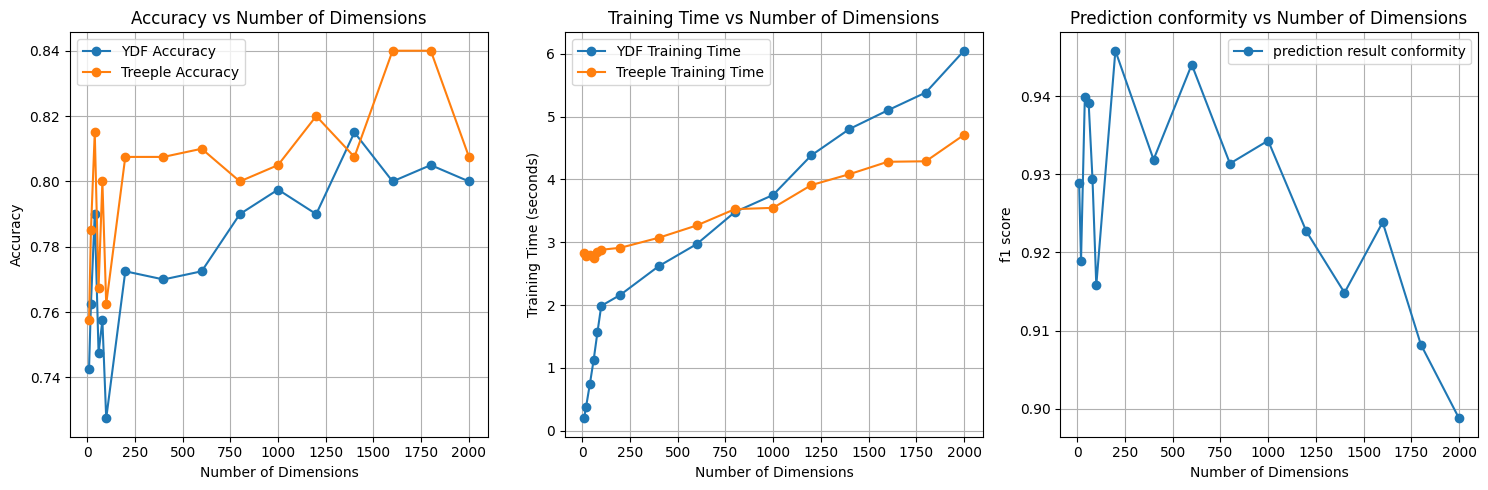

In [13]:
params_treeple1["max_leaf_nodes"] = 30
accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores = trunk_simulation(n_tree, 
                                                                               num_dims, 
                                                                               n_samples, 
                                                                               params_treeple1, 
                                                                               params_ydf1, 
                                                                               n_rep=3, 
                                                                               plot=True)

n_dim: 10 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.280741
Treeple: Accuracy = 0.7450, Training Time = 3.4592 sec
Train model on 1600 examples
Model trained in 0:00:00.257730
Treeple: Accuracy = 0.7450, Training Time = 3.4242 sec
Train model on 1600 examples
Model trained in 0:00:00.264325
Treeple: Accuracy = 0.7450, Training Time = 3.3831 sec
n_dim: 20 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.482655
Treeple: Accuracy = 0.7775, Training Time = 3.2527 sec
Train model on 1600 examples
Model trained in 0:00:00.478009
Treeple: Accuracy = 0.7775, Training Time = 3.2421 sec
Train model on 1600 examples
Model trained in 0:00:00.513635
Treeple: Accuracy = 0.7775, Training Time = 3.2486 sec
n_dim: 40 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 40. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.979708
Treeple: Accuracy = 0.8300, Training Time = 3.2746 sec
Train model on 1600 examples
Model trained in 0:00:00.975584
Treeple: Accuracy = 0.8300, Training Time = 3.2900 sec
Train model on 1600 examples
Model trained in 0:00:00.968398
Treeple: Accuracy = 0.8300, Training Time = 3.2772 sec
n_dim: 60 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 60. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.524990
Treeple: Accuracy = 0.7850, Training Time = 3.2854 sec
Train model on 1600 examples
Model trained in 0:00:01.525621
Treeple: Accuracy = 0.7850, Training Time = 3.2770 sec
Train model on 1600 examples
Model trained in 0:00:01.583322
Treeple: Accuracy = 0.7850, Training Time = 3.3942 sec
n_dim: 80 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 80. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:02.294615
Treeple: Accuracy = 0.8175, Training Time = 3.5286 sec
Train model on 1600 examples
Model trained in 0:00:02.242886
Treeple: Accuracy = 0.8175, Training Time = 3.5285 sec
Train model on 1600 examples
Model trained in 0:00:02.280842
Treeple: Accuracy = 0.8175, Training Time = 3.5139 sec
n_dim: 100 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:02.882979
Treeple: Accuracy = 0.7750, Training Time = 3.3020 sec
Train model on 1600 examples
Model trained in 0:00:02.882168
Treeple: Accuracy = 0.7750, Training Time = 3.3812 sec
Train model on 1600 examples
Model trained in 0:00:02.740909
Treeple: Accuracy = 0.7750, Training Time = 3.3517 sec
n_dim: 200 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:03.529529
Treeple: Accuracy = 0.8175, Training Time = 3.5716 sec
Train model on 1600 examples
Model trained in 0:00:03.473195
Treeple: Accuracy = 0.8175, Training Time = 3.6510 sec
Train model on 1600 examples
Model trained in 0:00:03.457826
Treeple: Accuracy = 0.8175, Training Time = 3.6161 sec
n_dim: 400 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 400. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:04.827550
Treeple: Accuracy = 0.8300, Training Time = 4.0182 sec
Train model on 1600 examples
Model trained in 0:00:04.865622
Treeple: Accuracy = 0.8300, Training Time = 4.0056 sec
Train model on 1600 examples
Model trained in 0:00:04.843911
Treeple: Accuracy = 0.8300, Training Time = 4.0081 sec
n_dim: 600 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:06.096311
Treeple: Accuracy = 0.8025, Training Time = 4.3950 sec
Train model on 1600 examples
Model trained in 0:00:06.197147
Treeple: Accuracy = 0.8025, Training Time = 4.3612 sec
Train model on 1600 examples
Model trained in 0:00:06.352594
Treeple: Accuracy = 0.8025, Training Time = 4.4693 sec
n_dim: 800 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:07.615544
Treeple: Accuracy = 0.8200, Training Time = 4.9139 sec
Train model on 1600 examples
Model trained in 0:00:07.625308
Treeple: Accuracy = 0.8200, Training Time = 4.7770 sec
Train model on 

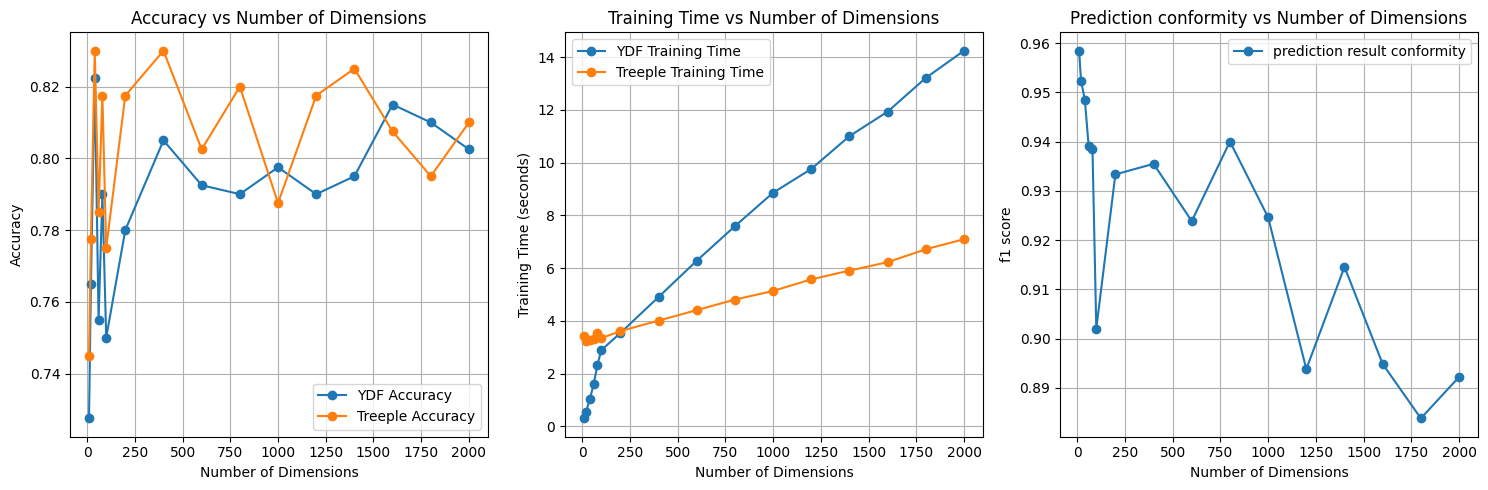

In [14]:
params_treeple1["max_leaf_nodes"] = None
params_ydf1["max_num_nodes"] = -1
accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores = trunk_simulation(n_tree, 
                                                                               num_dims, 
                                                                               n_samples, 
                                                                               params_treeple1, 
                                                                               params_ydf1, 
                                                                               n_rep=3, 
                                                                               plot=True)